# Genomic surveillance analysis in Germany

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import numpyro as npy
import numpyro.distributions as dist
import pandas as pd
from jax import random
import geopandas as gpd
import genomicsurveillance as gs ## misc branch on github

assert npy.__version__.startswith("0.8.0")
%matplotlib inline
%config InlineBackend.figure_format='retina'
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams.update({'axes.grid': True,
                     'grid.linestyle': ':',
                     'axes.spines.bottom': False,
          'axes.spines.left': False,
          'axes.spines.right': False,
          'axes.spines.top': False})

/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/jax/experimental/optimizers.py:30: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  FutureWarning)
/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/jax/experimental/stax.py:30: FutureWarning: jax.experimental.stax is deprecated, import jax.example_libraries.stax instead
  FutureWarning)


## Download data
### Map
With zip codes for geo matching

In [2]:
#plz = gpd.read_file("https://opendata.arcgis.com/datasets/5b203df4357844c8a6715d7d411a8341_0.geojson")
plz = gpd.read_file("data/5b203df4357844c8a6715d7d411a8341_0.geojson")
bland = plz.set_index("plz")['bundesland']

### Sequences
From RKI's Github

In [3]:
! bash scripts/pipeline.sh

+ bash scripts/download_data.sh
+ mkdir -p data/compressed
+ curl -L https://github.com/robert-koch-institut/SARS-CoV-2-Sequenzdaten_aus_Deutschland/raw/master/SARS-CoV-2-Sequenzdaten_Deutschland.csv.xz
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   210  100   210    0     0    161      0  0:00:01  0:00:01 --:--:--   161
100 40.8M  100 40.8M    0     0  1561k      0  0:00:26  0:00:26 --:--:-- 2578k
+ curl -L https://github.com/robert-koch-institut/SARS-CoV-2-Sequenzdaten_aus_Deutschland/raw/master/SARS-CoV-2-Entwicklungslinien_Deutschland.csv.xz
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   216  100   216    0     0    486      0 --:--:-- --:--:-- --:--:--   485
100 16.1M  100 16.1M    0     0   542k      0  0:00:30  0:00:30 --:--:--  799k96      0  0:07:

In [4]:
df = pd.read_csv(
    'data/meta_lineages.csv',
    index_col=0,
    parse_dates=[1,3],
    infer_datetime_format=True,
    cache_dates=True,
    dtype = {'SEQ_REASON': 'category',
             'SENDING_LAB_PC': 'category',
             'SEQUENCING_LAB_PC': 'category',
             'lineage': 'category',
             'scorpio_call': 'category'
             }
)
df.rename(columns={
    'DATE_DRAW': 'date',
    'PROCESSING_DATE': 'processing_date',
    'SEQ_REASON': 'reason',
    'SENDING_LAB_PC': 'sending_pc',
    'SEQUENCING_LAB_PC': 'sequencing_pc',
    'lineage': 'lineage',
    'scorpio_call': 'scorpio'
    },
    inplace=True
)

In [5]:
df = df[~ pd.isna(df.sending_pc)]
df.sending_pc = df.sending_pc.cat.rename_categories({x:f"{float(x):05.0f}" for x in df.sending_pc.cat.categories}) # = df.sending_pc.astype('str').astype('category')


In [6]:

df = df.merge(bland, left_on='sending_pc', right_index=True)#.dropna()


In [7]:
df.reason.value_counts()

N                             348932
X                             249445
A[B.1.1.7]                     35832
A[B.1.617.2]                   35581
Y                              26848
                               ...  
A[KONTAKTMITENGL.MUTATION]         0
A[B1.627.2]                        0
A[E484E/N501N/P681R]               0
A[E484K/N501Y/P681R]               0
A[B1.1.529]                        0
Name: reason, Length: 210, dtype: int64

In [8]:
import re

In [9]:
df

date reason  \
IMS_ID                                                                 
IMS-10294-CVDP-00001                               2021-01-14      X   
IMS-10294-CVDP-00325                               2020-11-08      X   
IMS-10294-CVDP-00326                               2020-11-08      X   
IMS-10294-CVDP-00327                               2020-11-08      X   
IMS-10294-CVDP-00329                               2020-11-09      X   
...                                                       ...    ...   
IMS-10116-CVDP-FE1A432E-80D7-498C-B1F3-5997C95D... 2022-03-04      N   
IMS-10116-CVDP-99241F0D-8013-4406-89C5-720018EC... 2022-03-04      N   
IMS-10116-CVDP-8160CD80-D716-4D7E-9D03-7BEE3078... 2022-03-03      N   
IMS-10116-CVDP-C0C4DD90-BB68-4519-9248-E200CFF6... 2022-03-04      N   
IMS-10116-CVDP-8F4BD757-1E50-44CB-B49D-EC7409AB... 2022-03-05      N   

                                                   processing_date sending_pc  \
IMS_ID                                                                          
IMS-10294-CVDP-00001                                    2021-01-25      40225   
IMS-10294-CVDP-00325                                    2021-02-14      40225   
IMS-10294-CVDP-00326                                    2021-02-14      40225   
IMS-10294-CVDP-00327                                    2021-02-14      40225   
IMS-10294-CVDP-00329                                    2021-02-14      40225   
...                                                            ...        ...   
IMS-10116-CVDP-FE1A432E-80D7-498C-B1F3-5997C95D...      2022-03-20      37081   
IMS-10116-CVDP-99241F0D-8013-4406-89C5-720018EC...      2022-03-20      37081   
IMS-10116-CVDP-8160CD80-D716-4D7E-9D03-7BEE3078...      2022-03-20      37081   
IMS-10116-CVDP-C0C4DD90-BB68-4519-9248-E200CFF6...      2022-03-20      37081   
IMS-10116-CVDP-8F4BD757-1E50-44CB-B49D-EC7409AB...      2022-03-20      37081   

                                                   sequencing_pc    lineage  \
IMS_ID                                                                        
IMS-10294-CVDP-00001                                     40225.0  B.1.1.297   
IMS-10294-CVDP-00325                                     40225.0    B.1.221   
IMS-10294-CVDP-00326                                     40225.0    B.1.160   
IMS-10294-CVDP-00327                                     40225.0    B.1.258   
IMS-10294-CVDP-00329                                     40225.0  B.1.1.521   
...                                                          ...        ...   
IMS-10116-CVDP-FE1A432E-80D7-498C-B1F3-5997C95D...       69126.0       BA.2   
IMS-10116-CVDP-99241F0D-8013-4406-89C5-720018EC...       69126.0       BA.2   
IMS-10116-CVDP-8160CD80-D716-4D7E-9D03-7BEE3078...       69126.0       BA.2   
IMS-10116-CVDP-C0C4DD90-BB68-4519-9248-E200CFF6...       69126.0       BA.2   
IMS-10116-CVDP-8F4BD757-1E50-44CB-B49D-EC7409AB...       69126.0     BA.1.1   

                                                                scorpio  \
IMS_ID                                                                    
IMS-10294-CVDP-00001                                                NaN   
IMS-10294-CVDP-00325                                                NaN   
IMS-10294-CVDP-00326                                                NaN   
IMS-10294-CVDP-00327                                                NaN   
IMS-10294-CVDP-00329                                                NaN   
...                                                                 ...   
IMS-10116-CVDP-FE1A432E-80D7-498C-B1F3-5997C95D...  Omicron (BA.2-like)   
IMS-10116-CVDP-99241F0D-8013-4406-89C5-720018EC...  Omicron (BA.2-like)   
IMS-10116-CVDP-8160CD80-D716-4D7E-9D03-7BEE3078...  Omicron (BA.2-like)   
IMS-10116-CVDP-C0C4DD90-BB68-4519-9248-E200CFF6...  Omicron (BA.2-like)   
IMS-10116-CVDP-8F4BD757-1E50-44CB-B49D-EC7409AB...  Omicron (BA.1-like)   

                                                             b

In [10]:
df.lineage[df.date > np.datetime64("today") - np.timedelta64(30, "D")].cat.remove_unused_categories().value_counts()

BA.2          40164
BA.1.1         9085
BA.1           3003
None            353
BA.3             10
B.1.177.86        8
B.1               5
AY.121            4
B.1.617.2         4
B.1.351           2
B.1.1.7           2
B.1.1             2
AY.43             2
AY.13             1
AY.4              1
AY.127            1
AY.122            1
AY.4.2.3          1
AY.127.1          1
Name: lineage, dtype: int64

In [11]:
import re

In [12]:
d = df.loc[df.date >= "2021-11-01",:]
d = d[d.reason.isin(['N','X'])]
d = d[d.lineage != "None"]
d.lineage = d.lineage.cat.add_categories(['Other'])
#d.lineage[d.lineage.isna()] = 'Other'
#d.loc[~d.lineage.isin(['BA.1','BA.1.1','BA.2','BA.3','B.1.1.529']),"lineage"] = "Delta/Other"
d.lineage.iloc[d.lineage.apply(lambda x: re.match("AY",x) is not None).astype("Bool")] = "B.1.617.2"
d.loc[~d.lineage.isin(['BA.1','BA.1.1','BA.2','BA.3','B.1.1.529','B.1.617.2']),"lineage"] = "Other"
genomes = pd.crosstab(index=[d.bundesland, d.date], columns=d.lineage.cat.remove_unused_categories(), dropna=False).fillna(0)
#genomes.loc["Baden-Württemberg"]
genomes = genomes.iloc[:,[1,2,3,4,5,0]]
genomes

lineage                       BA.1  BA.1.1  BA.2  BA.3  Other  B.1.617.2
bundesland        date                                                  
Baden-Württemberg 2021-11-01     0       0     0     0      0        142
                  2021-11-02     0       0     0     0      0        350
                  2021-11-03     0       0     0     0      0        704
                  2021-11-04     0       0     0     0      0       1044
                  2021-11-05     0       0     0     0      0       1210
...                            ...     ...   ...   ...    ...        ...
Thüringen         2022-03-25     0       0     0     0      0          0
                  2022-03-26     0       0     0     0      0          0
                  2022-03-27     0       0     0     0      0          0
                  2022-03-28     0       0     0     0      0          0
                  2022-03-29     0       0     0     0      0          0

[2384 rows x 6 columns]

In [13]:
genomes.sum(level=0)

lineage                  BA.1  BA.1.1   BA.2  BA.3  Other  B.1.617.2
bundesland                                                          
Baden-Württemberg       17489   23216  22247    10     32      41418
Bayern                   3496    5827   9881     1     29       6230
Berlin                    743     807   1492     0      5       2888
Brandenburg               964    1498   1761     1      0       2851
Bremen                    213     409    155     0      5        837
Hamburg                  4080    3663   2799     3     23       3769
Hessen                   1023    1697   1079     3      1       1643
Mecklenburg-Vorpommern    591     648    785     0      0       2825
Niedersachsen            1001    1286   1312     0      6       3018
Nordrhein-Westfalen     20622   24021  25166    17    166      26433
Rheinland-Pfalz           349     552    443     0      2       1511
Saarland                  831    1315    834     0      4       1777
Sachsen                  5339    8177   5292     2     32      15124
Sachsen-Anhalt           1745     718   1353     5      0       3003
Schleswig-Holstein       3439    4999   4977     4      2       3907
Thüringen                 363     731    536     0      8       1703

In [14]:
genomes.index.levels[0]

Index(['Baden-Württemberg', 'Bayern', 'Berlin', 'Brandenburg', 'Bremen',
       'Hamburg', 'Hessen', 'Mecklenburg-Vorpommern', 'Niedersachsen',
       'Nordrhein-Westfalen', 'Rheinland-Pfalz', 'Saarland', 'Sachsen',
       'Sachsen-Anhalt', 'Schleswig-Holstein', 'Thüringen'],
      dtype='object', name='bundesland')

In [15]:
G = genomes.values.reshape([len(genomes.index.levels[0]), len(genomes.index.levels[1]), -1])

### Cases
Also from RKI

In [16]:
cases_raw = pd.read_csv("https://media.githubusercontent.com/media/robert-koch-institut/SARS-CoV-2_Infektionen_in_Deutschland/master/Aktuell_Deutschland_SarsCov2_Infektionen.csv",  index_col=[0,1,2,4], parse_dates=True)

In [17]:
cases_raw

Meldedatum  \
IdLandkreis Altersgruppe Geschlecht Refdatum                 
1001        A15-A34      M          2020-01-19  2020-10-28   
                                    2020-03-13  2020-03-19   
                                    2020-03-13  2020-03-21   
            A35-A59      M          2020-03-16  2020-03-14   
            A15-A34      M          2020-03-16  2020-03-19   
...                                                    ...   
16077       A05-A14      W          2022-03-31  2022-03-31   
            A15-A34      W          2022-03-31  2022-03-31   
            A35-A59      W          2022-03-31  2022-03-31   
            unbekannt    W          2022-03-31  2022-03-31   
            A60-A79      W          2022-03-31  2022-03-31   

                                                IstErkrankungsbeginn  \
IdLandkreis Altersgruppe Geschlecht Refdatum                           
1001        A15-A34      M          2020-01-19                     1   
                                    2020-03-13                     1   
                                    2020-03-13                     1   
            A35-A59      M          2020-03-16                     1   
            A15-A34      M          2020-03-16                     1   
...                                                              ...   
16077       A05-A14      W          2022-03-31                     0   
            A15-A34      W          2022-03-31                     0   
            A35-A59      W          2022-03-31                     0   
            unbekannt    W          2022-03-31                     0   
            A60-A79      W          2022-03-31                     0   

                                                NeuerFall  NeuerTodesfall  \
IdLandkreis Altersgruppe Geschlecht Refdatum                                
1001        A15-A34      M          2020-01-19          0              -9   
                                    2020-03-13          0              -9   
                                    2020-03-13          0              -9   
            A35-A59      M          2020-03-16          0              -9   
            A15-A34      M          2020-03-16          0              -9   
...                                                   ...             ...   
16077       A05-A14      W          2022-03-31          1              -9   
            A15-A34      W          2022-03-31          1              -9   
            A35-A59      W          2022-03-31          1              -9   
            unbekannt    W          2022-03-31          1              -9   
            A60-A79      W          2022-03-31          1              -9   

                                                NeuGenesen  AnzahlFall  \
IdLandkreis Altersgruppe Geschlecht Refdatum                             
1001        A15-A34      M          2020-01-19           0           1   
                                    2020-03-13           0           1   
                                    2020-03-13           0           1   
            A35-A59      M          2020-03-16           0           1   
            A15-A34      M          2020-03-16           0           1   
...                                                    ...         ...   
16077       A05-A14      W          2022-03-31          -9          13   
            A15-A34      W          2022-03-31          -9           8   
            A35-A59      W          2022-03-31          -9          28   
            unbekannt    W          2022-03-31          -9           1   
            A60-A79      W          2022-03-31          -9          12   

                                                AnzahlTodesfall  AnzahlGenesen  
IdLandkreis Altersgruppe Geschlecht Refdatum                                    
1001        A15-A34      M          2020-01-19                0              1  
                                    2020-03-13                0              1  
               

### Registration delays

In [18]:
f = cases_raw.reset_index(level=3)[['Refdatum','Meldedatum','AnzahlFall'] ].reset_index()
f['Delta'] = np.clip(pd.to_datetime(f['Meldedatum']) - f['Refdatum'], np.timedelta64(0,"D"), np.timedelta64(10,"D"))
f['bundesland'] = (f.IdLandkreis/1000).astype("int")

f= f.set_index(["bundesland","IdLandkreis","Altersgruppe","Geschlecht","Refdatum","Delta"]).sum(level=[0,4,5]).sort_index()
f = f.unstack(level=2)["AnzahlFall"].sort_index().loc[:,"2022-02-01":,:]#.loc[:,"2021-11-01":]
f /= f.sum(1).values[:,np.newaxis]

<AxesSubplot:xlabel='bundesland,Refdatum'>

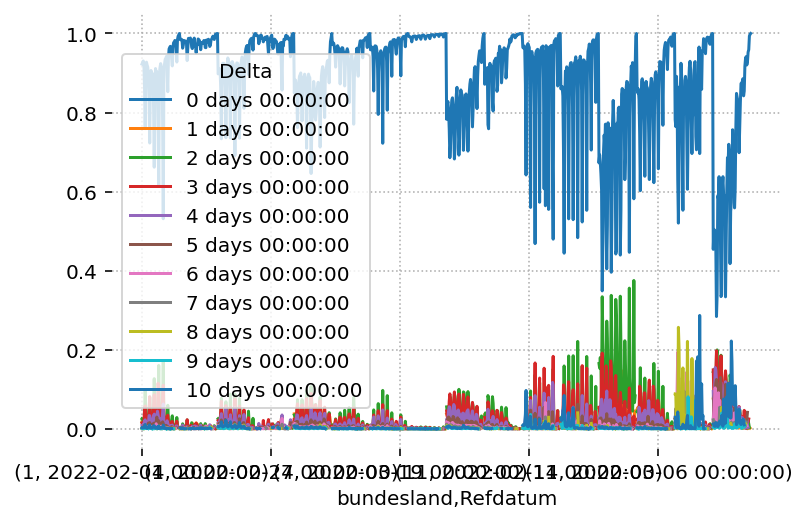

In [19]:
f.plot()

In [20]:
f['weekday'] = f.reset_index()['Refdatum'].dt.strftime("%a").values

In [21]:
f = f.reset_index().set_index(["bundesland","Refdatum","weekday"]).cumsum(1).mean(level=[0,2]).fillna(1)

In [22]:
f.loc[1]

Delta    0 days 00:00:00  1 days 00:00:00  2 days 00:00:00  3 days 00:00:00  \
weekday                                                                       
Tue             0.937382         0.953035         0.975117         0.985845   
Wed             0.937562         0.955426         0.972965         0.981306   
Thu             0.938281         0.950165         0.963415         0.967839   
Fri             0.924419         0.935549         0.944301         0.965476   
Sat             0.854085         0.863939         0.905603         0.955962   
Sun             0.748425         0.790325         0.884653         0.946609   
Mon             0.912702         0.935070         0.963989         0.981842   

Delta    4 days 00:00:00  5 days 00:00:00  6 days 00:00:00  7 days 00:00:00  \
weekday                                                                       
Tue             0.990246         0.991396         0.994928         0.996806   
Wed             0.983698         0.990703         0.995320         0.997394   
Thu             0.981009         0.991586         0.995545         0.996898   
Fri             0.983771         0.991911         0.994994         0.996083   
Sat             0.981043         0.989941         0.992442         0.993463   
Sun             0.973216         0.980971         0.984760         0.986179   
Mon             0.989122         0.991805         0.992093         0.995376   

Delta    8 days 00:00:00  9 days 00:00:00  10 days 00:00:00  
weekday                                                      
Tue             0.997760         0.998393               1.0  
Wed             0.998355         0.998667               1.0  
Thu             0.997746         0.997543               1.0  
Fri             0.996417         0.996618               1.0  
Sat             0.993967         0.995696               1.0  
Sun             0.990793         0.993263               1.0  
Mon             0.996902         0.998066               1.0

In [23]:
reporting_lag = np.array([f.loc[:,d.strftime("%a"),:].iloc[:,(cases_raw.index.levels[3][-1]-d).days] for d in cases_raw.index.levels[3][-9:]]).T

In [24]:
s="""01  Schleswig-Holstein
02  Hamburg
03  Niedersachsen
04  Bremen
05  Nordrhein-Westfalen
06  Hessen
07  Rheinland-Pfalz
08  Baden-Württemberg
09  Bayern
10  Saarland
11  Berlin
12  Brandenburg
13  Mecklenburg-Vorpommern
14  Sachsen
15  Sachsen-Anhalt
16  Thüringen"""
b={int(x.split()[0]): x.split()[1] for x in s.split("\n")}

In [25]:
current_lag = pd.DataFrame(reporting_lag, index=np.arange(1,17)).rename(index=b).sort_index()
current_lag

0         1         2         3         4  \
Baden-Württemberg       0.999854  0.999835  0.999639  0.999326  0.998411   
Bayern                  0.997502  0.995960  0.991890  0.983977  0.965084   
Berlin                  0.996511  0.995744  0.993657  0.974553  0.911710   
Brandenburg             0.993604  0.991768  0.988508  0.972259  0.924349   
Bremen                  0.999830  0.999790  0.999432  0.995137  0.987494   
Hamburg                 0.999298  0.998508  0.998227  0.995347  0.992699   
Hessen                  0.999302  0.999047  0.998602  0.996862  0.990365   
Mecklenburg-Vorpommern  0.998391  0.997466  0.995035  0.992079  0.972610   
Niedersachsen           0.995676  0.993824  0.990751  0.981323  0.952987   
Nordrhein-Westfalen     0.997251  0.996356  0.992351  0.985302  0.966107   
Rheinland-Pfalz         0.999275  0.998750  0.997737  0.995198  0.981894   
Saarland                0.999154  0.998555  0.997946  0.997797  0.987762   
Sachsen                 0.999057  0.998443  0.996625  0.993761  0.981893   
Sachsen-Anhalt          0.983961  0.994983  0.948679  0.885412  0.807109   
Schleswig-Holstein      0.998355  0.996898  0.994994  0.989941  0.973216   
Thüringen               0.960418  0.951569  0.949339  0.936694  0.850265   

                               5         6         7         8  
Baden-Württemberg       0.998140  0.997782  0.996772  0.995999  
Bayern                  0.942797  0.924563  0.905355  0.886751  
Berlin                  0.985575  0.954186  0.971435  0.968929  
Brandenburg             0.972882  0.967090  0.949994  0.941743  
Bremen                  0.992146  0.990596  0.988430  0.987830  
Hamburg                 0.994527  0.989499  0.988512  0.985129  
Hessen                  0.990186  0.985829  0.977748  0.969699  
Mecklenburg-Vorpommern  0.965727  0.947858  0.864696  0.815116  
Niedersachsen           0.961493  0.963854  0.953478  0.945617  
Nordrhein-Westfalen     0.961859  0.946772  0.927547  0.907319  
Rheinland-Pfalz         0.990918  0.985369  0.979937  0.977316  
Saarland                0.977468  0.975109  0.963541  0.959864  
Sachsen                 0.980257  0.972628  0.947151  0.918083  
Sachsen-Anhalt          0.872704  0.887115  0.913042  0.945229  
Schleswig-Holstein      0.981842  0.975117  0.955426  0.938281  
Thüringen               0.844659  0.815331  0.785791  0.757581

In [26]:
cases = cases_raw['AnzahlFall'].sum(level=(0,3)).sort_index()

In [27]:
cases_land = cases.reset_index()
cases_land['bundesland'] = (cases_land.IdLandkreis/1000).astype("int")
cases_land = cases_land.set_index(['bundesland', 'IdLandkreis','Refdatum']).sum(level=(0,2)).sort_index()
cases_land = cases_land.rename(index=b).sort_index()
cases_land = cases_land.loc[:,"2021-11-01":,:].unstack()["AnzahlFall"]#.iloc[:,:-1]
#cases_land.iloc[:,-9:] = (cases_land.iloc[:,-9:] / reporting_lag).astype("int32")
cases_land

Refdatum                2021-11-01  2021-11-02  2021-11-03  2021-11-04  \
bundesland                                                               
Baden-Württemberg             2145        2959        4425        4619   
Bayern                        5950        7034        9175        8945   
Berlin                        1325        1322        1440        1434   
Brandenburg                    814         983        1073        1056   
Bremen                          79          89          69          62   
Hamburg                        320         457         540         503   
Hessen                        1194        1595        1705        1573   
Mecklenburg-Vorpommern         418         428         405         317   
Niedersachsen                 1186        1453        1673        1370   
Nordrhein-Westfalen           2565        3467        4353        4360   
Rheinland-Pfalz                642         990        1127        1079   
Saarland                       127         123         203         230   
Sachsen                       2840        3670        3476        3313   
Sachsen-Anhalt                 647         855         722         738   
Schleswig-Holstein             336         389         367         354   
Thüringen                     1823        1430        1426        1502   

Refdatum                2021-11-05  2021-11-06  2021-11-07  2021-11-08  \
bundesland                                                               
Baden-Württemberg             5068        4128        2276        4390   
Bayern                        9250        8799        7238        9336   
Berlin                        1451         968         753        2176   
Brandenburg                   1184        1118         981        1263   
Bremen                          55          55          31          60   
Hamburg                        556         471         410         481   
Hessen                        1689        1313        1092        1468   
Mecklenburg-Vorpommern         544         505         314         528   
Niedersachsen                 1401        1164         844        1621   
Nordrhein-Westfalen           4074        3721        2976        4434   
Rheinland-Pfalz               1027         808         764        1082   
Saarland                       185         214         155         209   
Sachsen                       3467        3192        2666        4438   
Sachsen-Anhalt                 729         659         899         669   
Schleswig-Holstein             435         382         298         449   
Thüringen                     1429        1755        1189        1856   

Refdatum                2021-11-09  2021-11-10  ...  2022-03-22  2022-03-23  \
bundesland                                      ...                           
Baden-Württemberg             7119        7755  ...       40130       42548   
Bayern                       11246       12160  ...       52752       55517   
Berlin                        1921        2399  ...        9451        9043   
Brandenburg                   1500        1689  ...        8749        7760   
Bremen                         143          95  ...        1704        1703   
Hamburg                        530         569  ...        5196        5216   
Hessen                        1791        2066  ...       17241       19053   
Mecklenburg-Vorpommern         597         468  ...        8995        7103   
Niedersachsen                 1754        2165  ...       32670       32557   
Nordrhein-Westfalen           5152        5324  ...       50753       52595   
Rheinland-Pfalz               1139        1329  ...       14158       15148   
Saarland                       273         301  ...        4515        3921   
Sachsen                       5757        5990  ...       20268       17633   
Sachsen-Anhalt                1019        1178  ...        8320        8223   
Schleswig-Holstein             486         542  ...        9887       

In [28]:
cases_land.sum(0)

Refdatum
2021-11-01     22411
2021-11-02     27244
2021-11-03     32179
2021-11-04     31455
2021-11-05     32544
               ...  
2022-03-27     67376
2022-03-28    194416
2022-03-29    255264
2022-03-30    235585
2022-03-31    162816
Length: 151, dtype: int64

In [29]:
clip = 1
cases_land.iloc[:,-9:] = (cases_land.iloc[:,-9:] / current_lag.values)#.astype("int32")
cases_land.loc["Hamburg"].iloc[-2:] = np.nan
cases_land = cases_land.iloc[:,:cases_land.shape[1]-clip]
cases_land

/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Refdatum                2021-11-01  2021-11-02  2021-11-03  2021-11-04  \
bundesland                                                               
Baden-Württemberg             2145        2959        4425        4619   
Bayern                        5950        7034        9175        8945   
Berlin                        1325        1322        1440        1434   
Brandenburg                    814         983        1073        1056   
Bremen                          79          89          69          62   
Hamburg                        320         457         540         503   
Hessen                        1194        1595        1705        1573   
Mecklenburg-Vorpommern         418         428         405         317   
Niedersachsen                 1186        1453        1673        1370   
Nordrhein-Westfalen           2565        3467        4353        4360   
Rheinland-Pfalz                642         990        1127        1079   
Saarland                       127         123         203         230   
Sachsen                       2840        3670        3476        3313   
Sachsen-Anhalt                 647         855         722         738   
Schleswig-Holstein             336         389         367         354   
Thüringen                     1823        1430        1426        1502   

Refdatum                2021-11-05  2021-11-06  2021-11-07  2021-11-08  \
bundesland                                                               
Baden-Württemberg             5068        4128        2276        4390   
Bayern                        9250        8799        7238        9336   
Berlin                        1451         968         753        2176   
Brandenburg                   1184        1118         981        1263   
Bremen                          55          55          31          60   
Hamburg                        556         471         410         481   
Hessen                        1689        1313        1092        1468   
Mecklenburg-Vorpommern         544         505         314         528   
Niedersachsen                 1401        1164         844        1621   
Nordrhein-Westfalen           4074        3721        2976        4434   
Rheinland-Pfalz               1027         808         764        1082   
Saarland                       185         214         155         209   
Sachsen                       3467        3192        2666        4438   
Sachsen-Anhalt                 729         659         899         669   
Schleswig-Holstein             435         382         298         449   
Thüringen                     1429        1755        1189        1856   

Refdatum                2021-11-09  2021-11-10  ...  2022-03-21  2022-03-22  \
bundesland                                      ...                           
Baden-Württemberg             7119        7755  ...       32304       40130   
Bayern                       11246       12160  ...       40579       52752   
Berlin                        1921        2399  ...        8805        9451   
Brandenburg                   1500        1689  ...        7132        8749   
Bremen                         143          95  ...        1402        1704   
Hamburg                        530         569  ...        4724        5196   
Hessen                        1791        2066  ...       17101       17241   
Mecklenburg-Vorpommern         597         468  ...        4925        8995   
Niedersachsen                 1754        2165  ...       22676       32670   
Nordrhein-Westfalen           5152        5324  ...       42790       50753   
Rheinland-Pfalz               1139        1329  ...       12701       14158   
Saarland                       273         301  ...        2183        4515   
Sachsen                       5757        5990  ...       15332       20268   
Sachsen-Anhalt                1019        1178  ...        6340        8320   
Schleswig-Holstein             486         542  ...        7200       

In [30]:
C = cases_land.values

### Population data
From Destatis

In [31]:
capita = pd.read_csv("data/12411-0010.csv", index_col=0)["Population"]
capita

Baden-Württemberg         11103043
Bayern                    13140183
Berlin                     3664088
Brandenburg                2531071
Bremen                      680130
Hamburg                    1852478
Hessen                     6293154
Mecklenburg-Vorpommern     1610774
Niedersachsen              8003421
Nordrhein-Westfalen       17925570
Rheinland-Pfalz            4098391
Saarland                    983991
Sachsen                    4056941
Sachsen-Anhalt             2180684
Schleswig-Holstein         2910875
Thüringen                  2120237
Name: Population, dtype: int64

In [32]:
131 % 10

1

## Modeling
### Basis functions

In [33]:
from genomicsurveillance.misc import fused_basis
n = C.shape[1]+clip
#B0 = fused_basis(n, inc=10, fuse=4, pad=28 - n % 10) ## cubic spline basis every 10d, last 4 linearly fused to avoid wriggles 
B0 = fused_basis(n+2, inc=7, fuse=5, pad=30 - n % 7)## cubic spline basis every 7d, last 5 linearly fused to avoid wriggles 
B0 = np.stack([B0[0,2:,:],B0[1,:-2,:]])

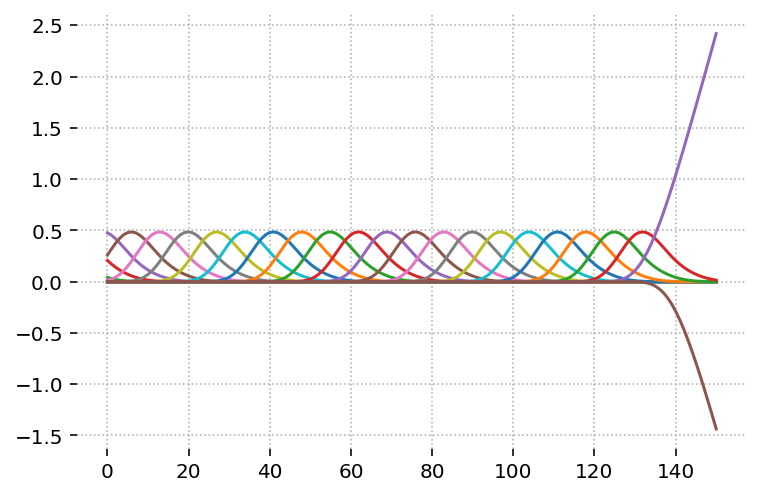

In [34]:
for i in range(B0.shape[-1]):
    plt.plot(B0[0,:,i])

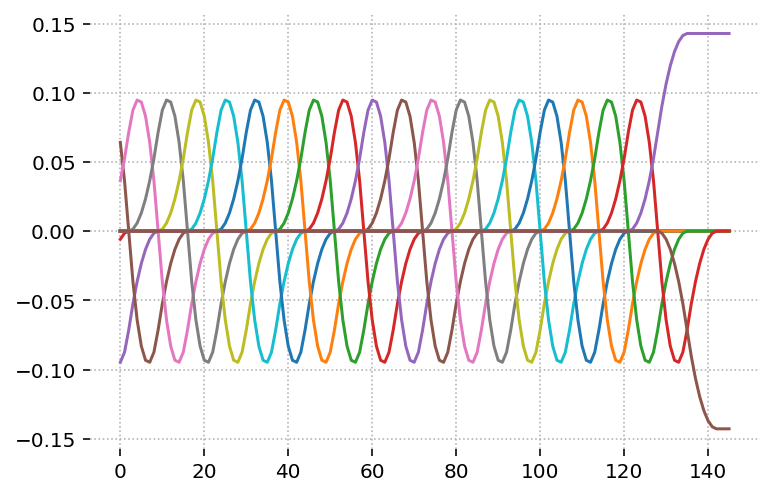

In [35]:
for i in range(B0.shape[-1]):
    plt.plot(B0[1,:-5,i])

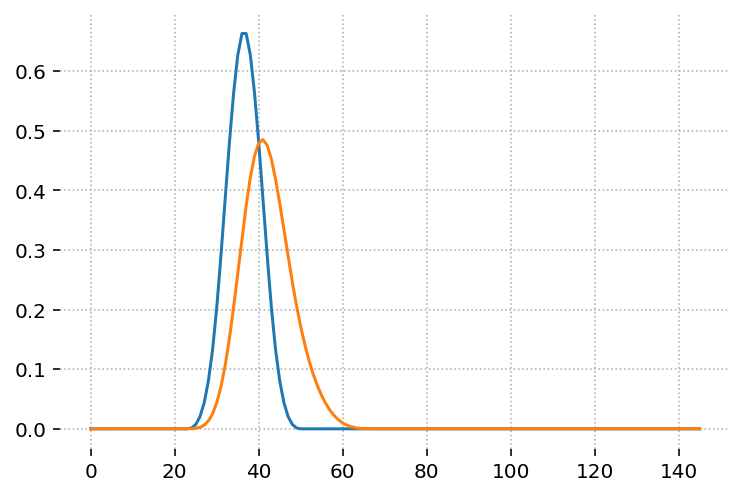

In [36]:
plt.plot(B0[1,:-5,10].cumsum())
plt.plot(B0[0,:-5,10])


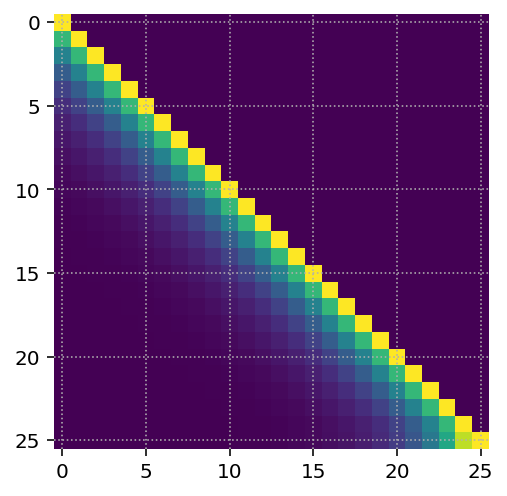

In [37]:
arma2 = np.eye(B0.shape[-1]) ## Prior covariance matrix for the splines to avoid too many wrinkles
for j in range(arma2.shape[0]-1):
    arma2[j+1,j] = -0.667
arma2[-1,-2] = -.9
arma2 = np.linalg.inv(arma2)
plt.imshow(arma2)

### Case and genome data
Prepare as arrays and add Germany as a whole

In [38]:
seq_index = np.array([list(cases_land.columns).index(i) for i in genomes.index.levels[1]])

In [39]:
import importlib
importlib.reload(gs.misc.misc)
importlib.reload(gs.misc)
from genomicsurveillance.misc import MultiLineageTimeShift, plot_lad, plot_growth_rates

In [40]:
from numpyro.infer import Trace_ELBO

In [41]:
GG = np.concatenate([G, G.sum(0, keepdims=True)], axis=0) # Add Germany as a whole
CC = np.concatenate([C, C.sum(0, keepdims=True)], axis=0)    

In [42]:
CC[2,cases_land.columns == np.datetime64("2022-03-08")] = np.nan # int women's day in Berlin..

### Model
Multi-lineage model with variable growth rates (random effect) across states

In [43]:
model = MultiLineageTimeShift(
    CC,
    GG,    
    seq_index,
    np.concatenate([capita.values, capita.values.sum().reshape(1)]),
    #auto_correlation=0.5,
    #linearize=True,
    arma = arma2,
    b_scale=0.01,
    b0_scale=0.3,
    c_scale=20,
    beta_scale= np.append(10.,np.repeat(10., B0.shape[2]-1)),# np.concatenate([np.repeat(1., knots.num_long_basis), np.repeat(.1, knots.num_short_basis)]),
    tau=4.6,
    basis=B0, #knots.basis,
    shift=7,  
    alpha0=.01,
    alpha1=100., 
    week=True,
    fit_logits=True,
    #model_kwargs={'handler':'SVI', 'loss':Trace_ELBO(num_particles=5), 'num_epochs':10000, 'lr':0.001, 'num_samples': 100}
    model_kwargs={'handler':'SVI', 'loss':Trace_ELBO(num_particles=10), 'num_epochs':10000, 'lr':0.005, 'lrd': 0.1 ** (1/10000), 'num_samples': 100}

)

In [44]:
model.fit()

/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/jax/_src/numpy/lax_numpy.py:6576: UserWarning: Explicitly requested dtype float requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


SVI step 0 / 10,000 | 0 %
SVI step 1,000 / 10,000 | 10 %
SVI step 2,000 / 10,000 | 20 %
SVI step 3,000 / 10,000 | 30 %
SVI step 4,000 / 10,000 | 40 %
SVI step 5,000 / 10,000 | 50 %
SVI step 6,000 / 10,000 | 60 %
SVI step 7,000 / 10,000 | 70 %
SVI step 8,000 / 10,000 | 80 %
SVI step 9,000 / 10,000 | 90 %


Text(0, 0.5, 'ELBO')

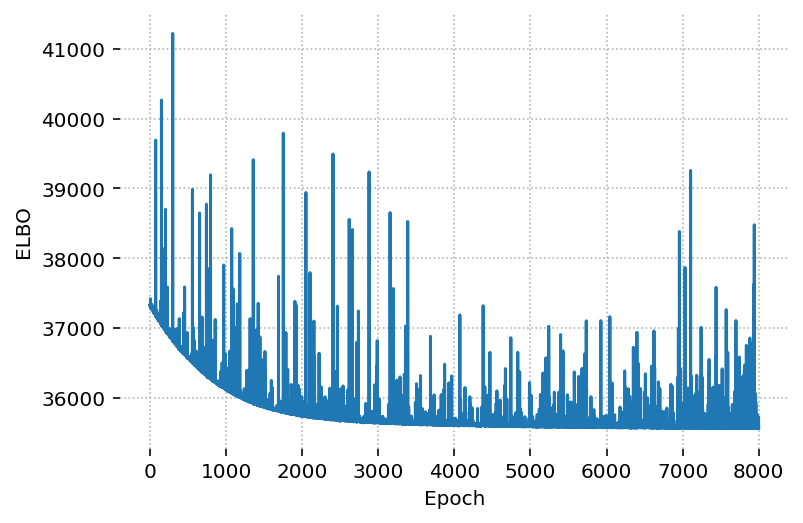

In [45]:
plt.plot(model.loss[2000:])
plt.xlabel('Epoch')
plt.ylabel('ELBO')
#plt.ylim((None, model.loss[2000]))

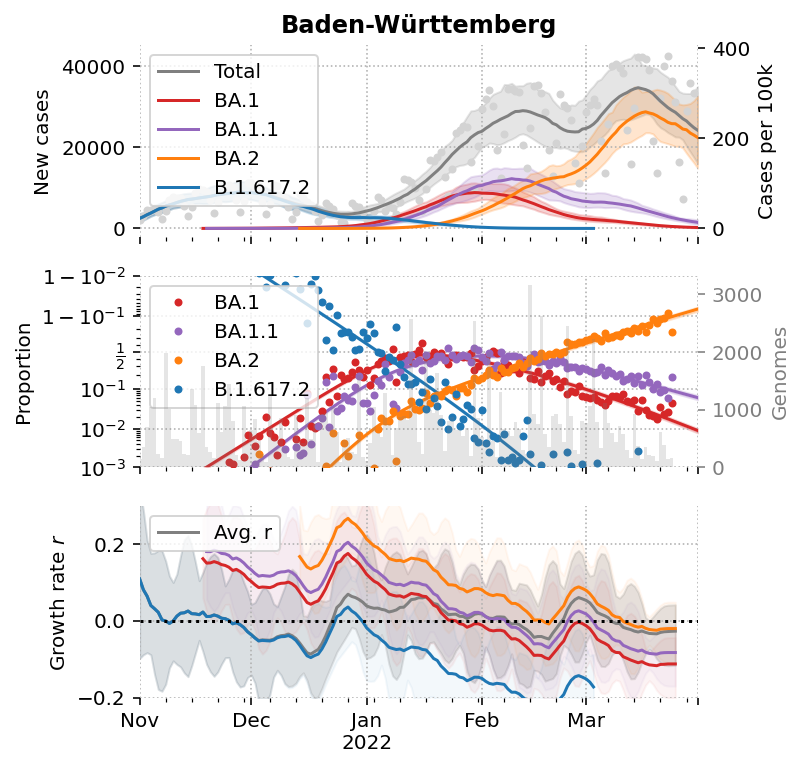

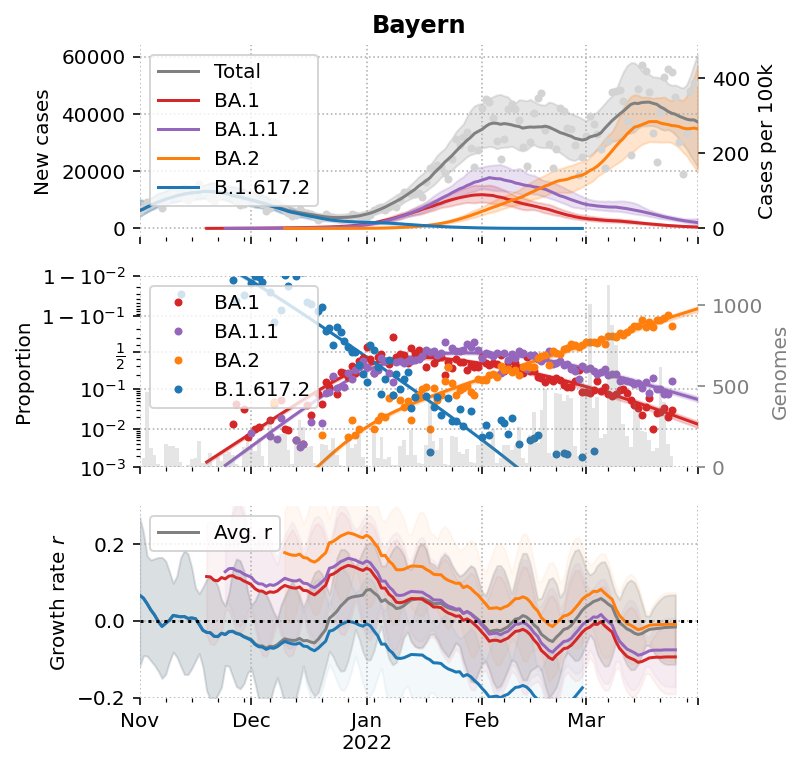

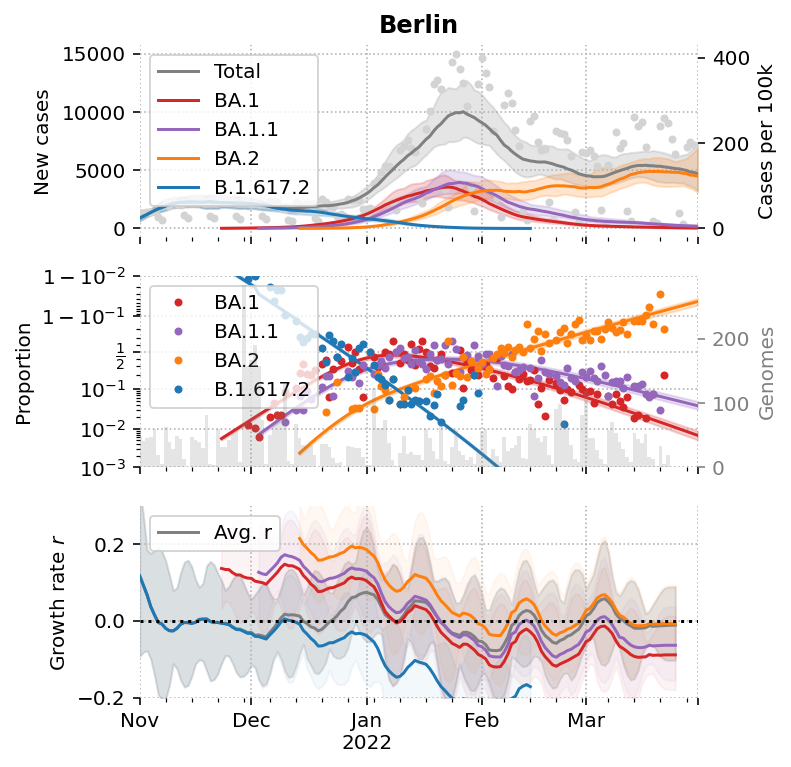

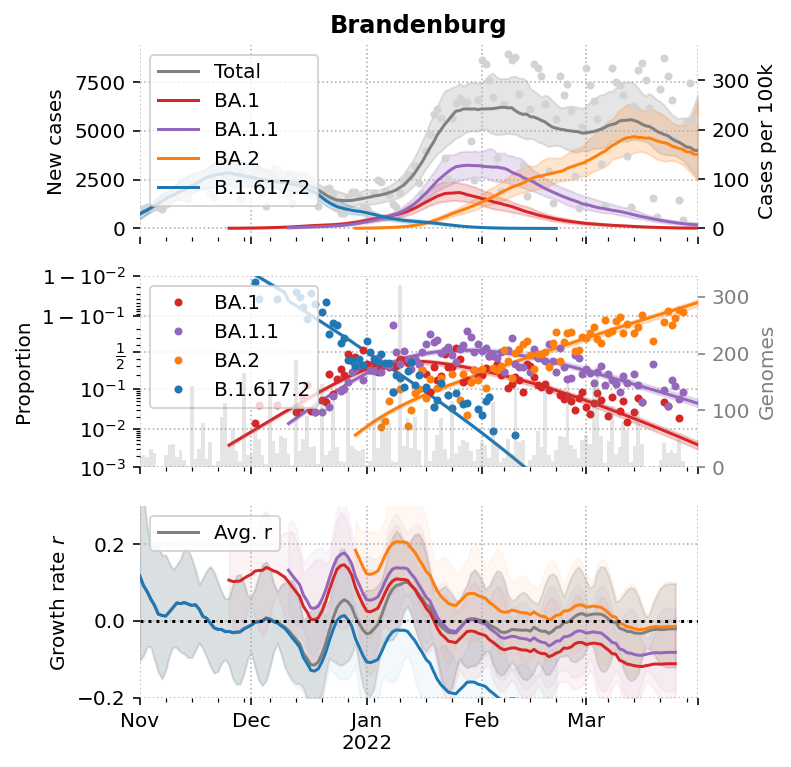

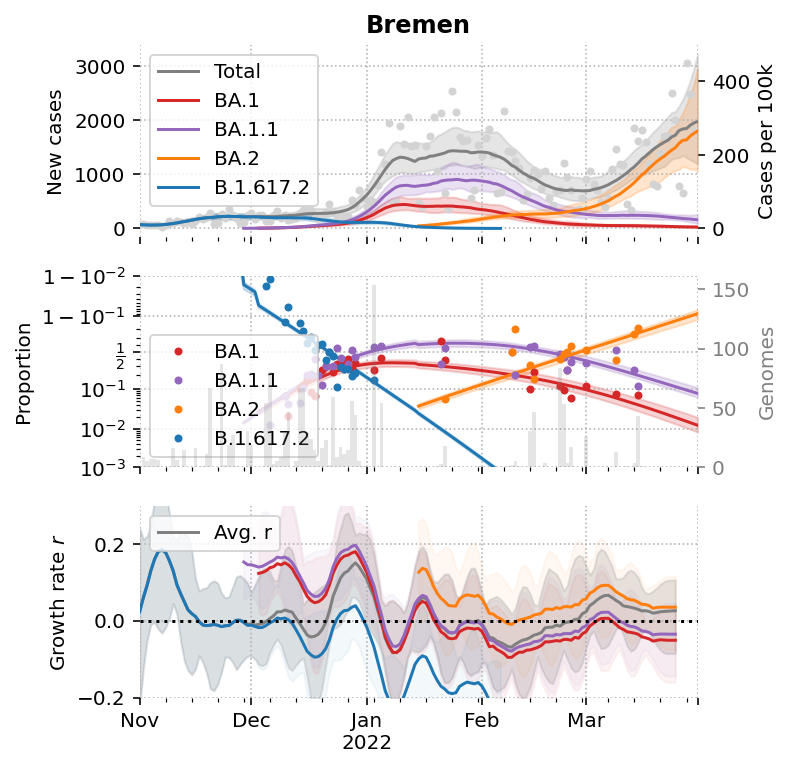

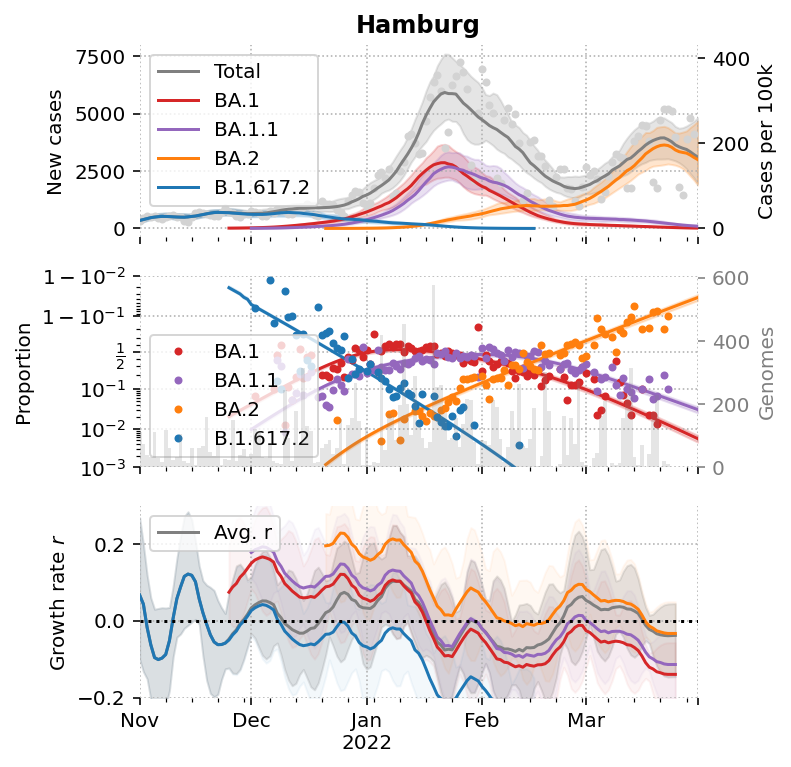

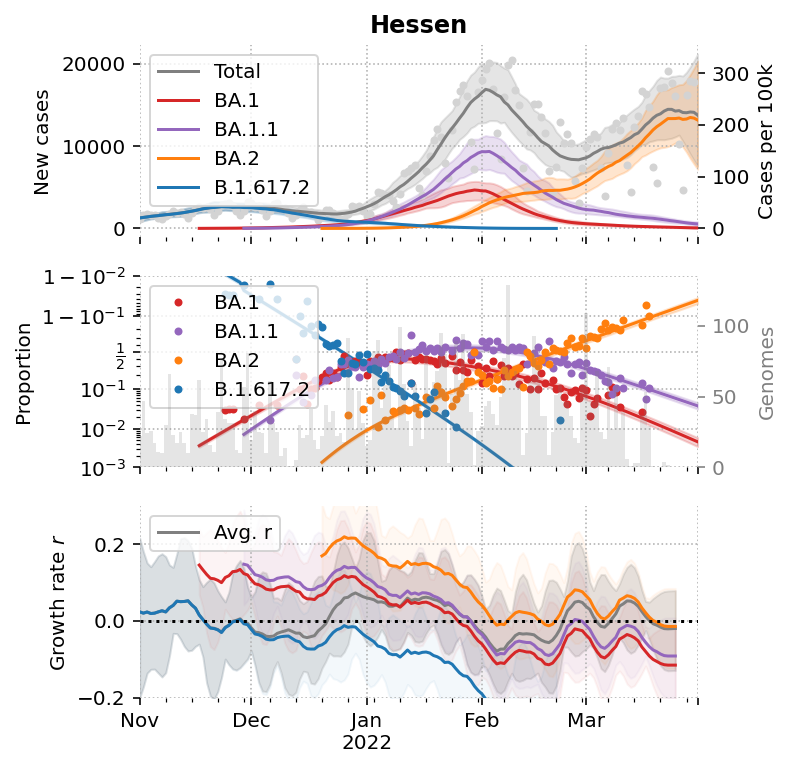

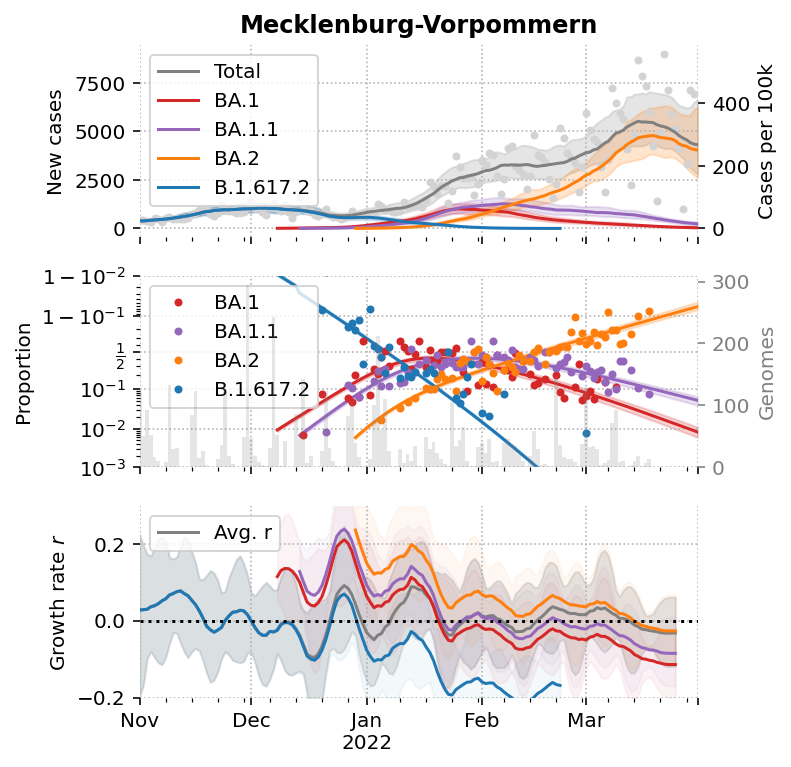

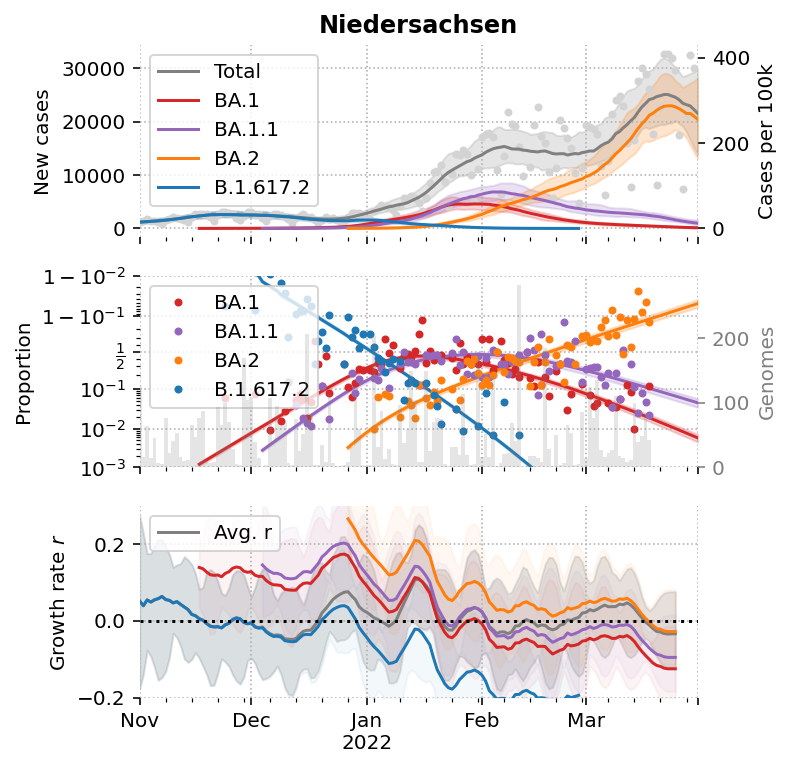

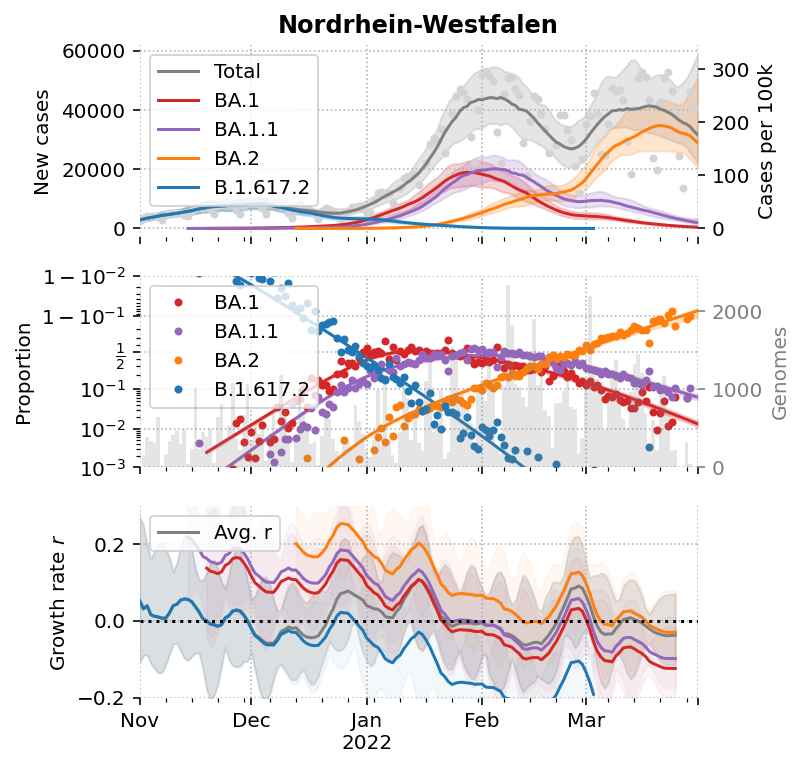

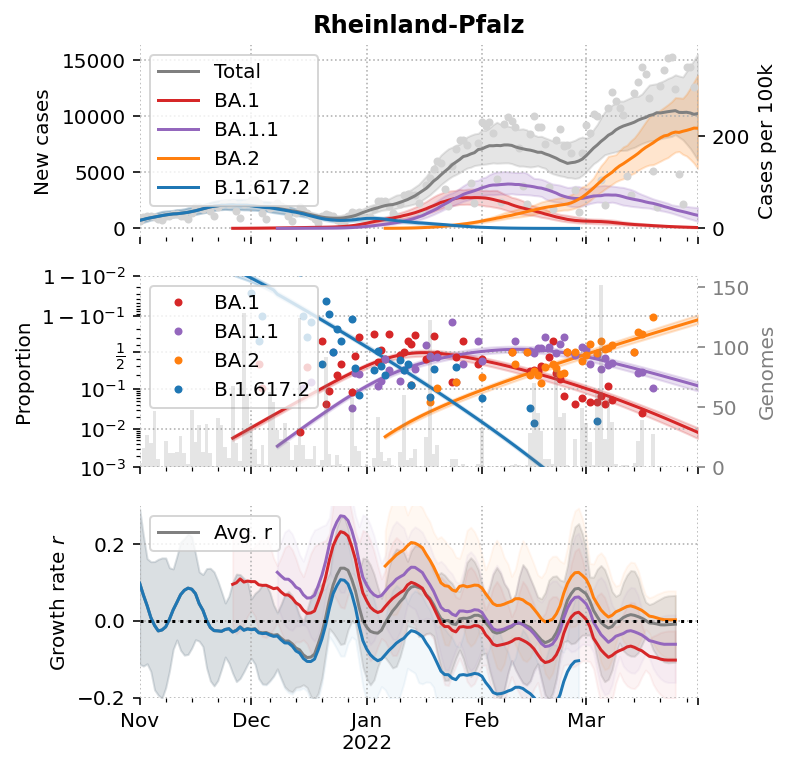

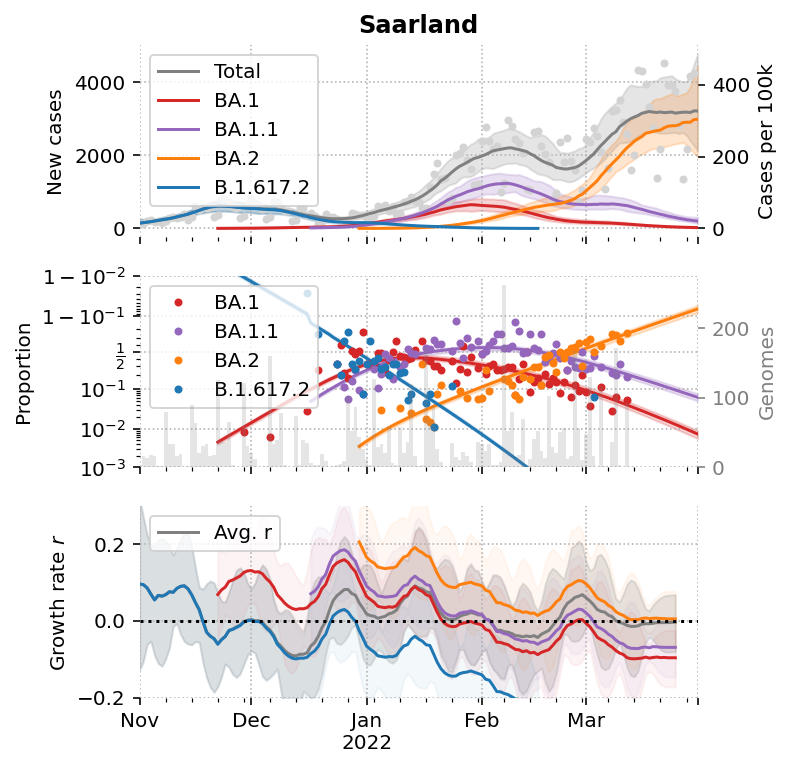

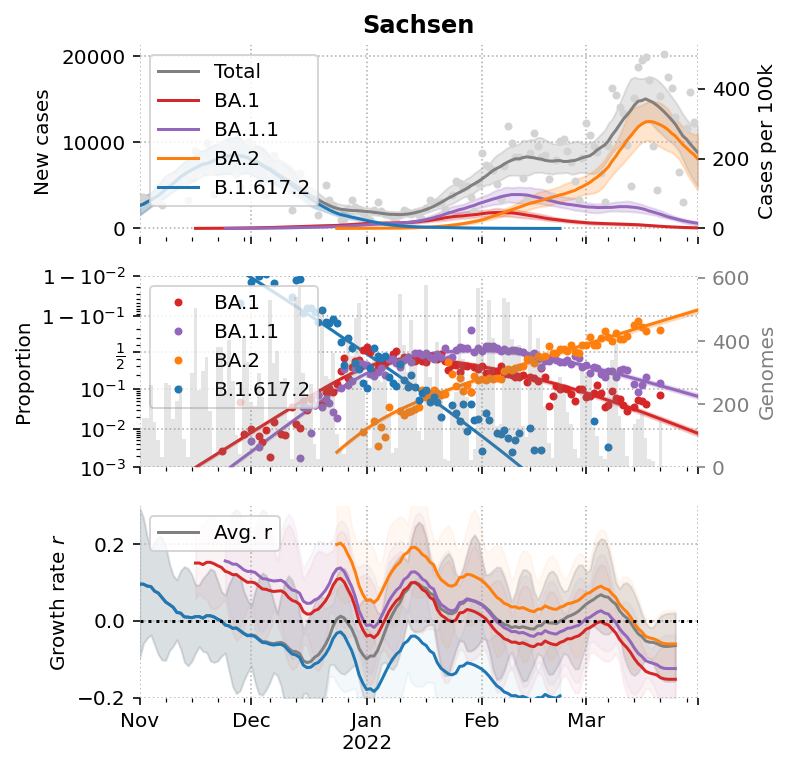

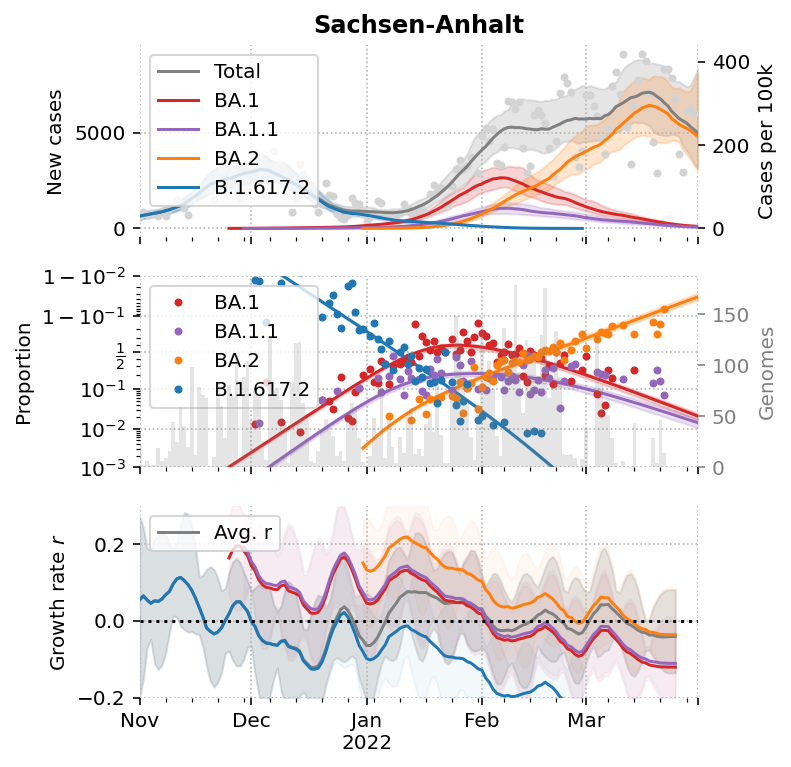

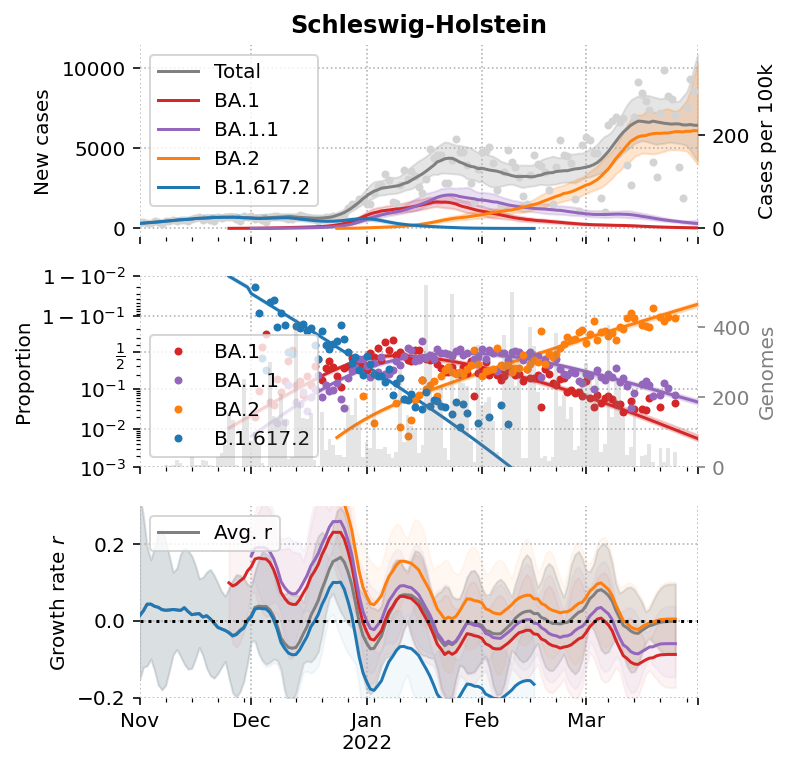

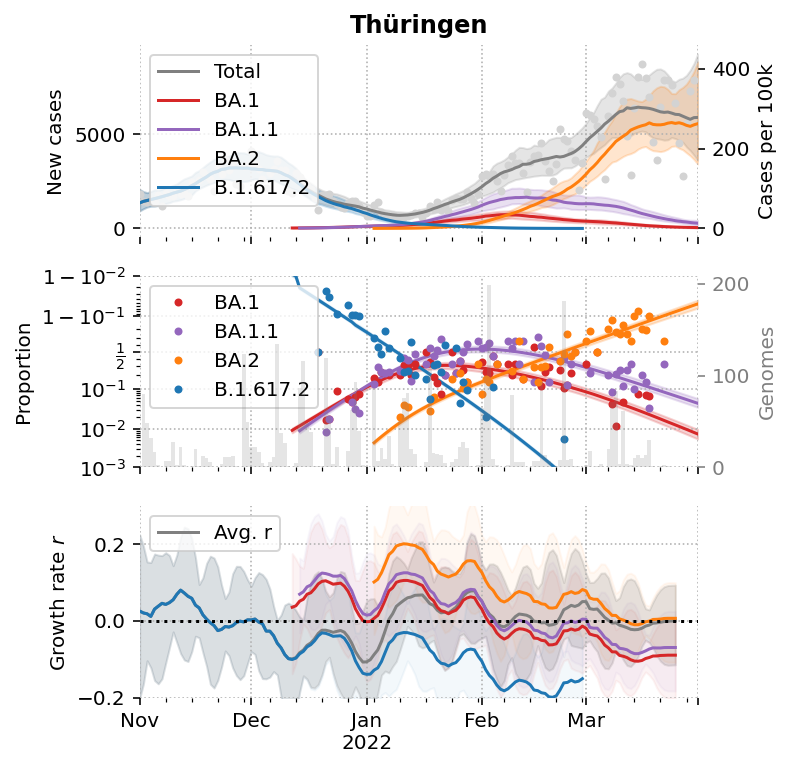

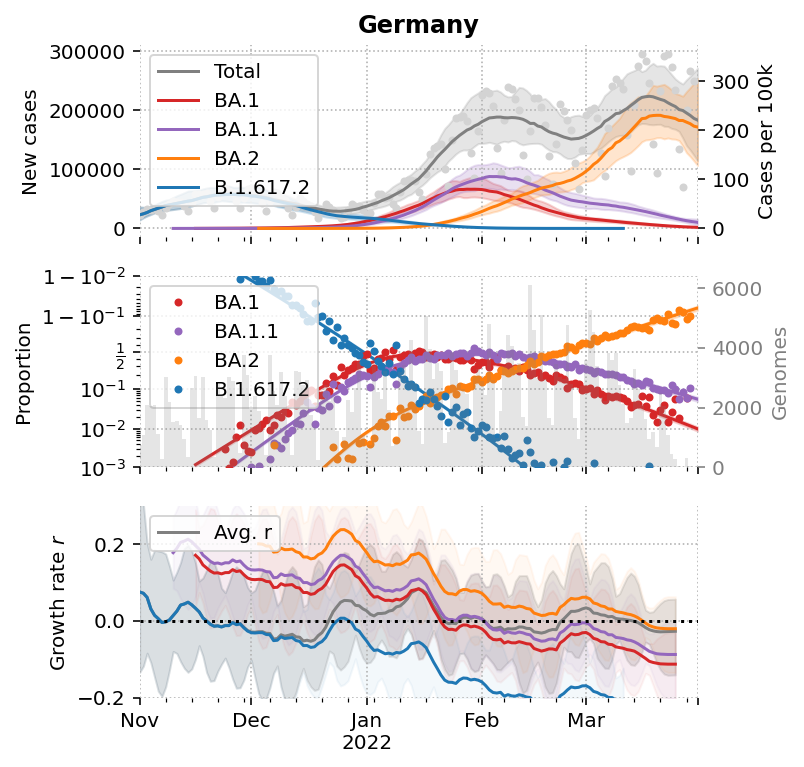

In [46]:
#from genomicsurveillance.plots.england import plot_lad, 
from genomicsurveillance.plots.england import plot_median_and_ci
for i,r in enumerate(cases_land.index.to_list() + ["Germany"]):
    w = np.where(GG[i].sum(0) >= 1)[0]
    w = list(set(w) - set([3,4]))
    plot_lad(model, i, CC, GG, seq_index, start_date="2021-11-01", show_start_date="2021-11-01",
        lin = w,
        labels = genomes.columns[w],
        lin_colors=np.array(['C3',"C4","C1", "C6","C5" ,"C0", "C9","C0"])[w],#, "C6", "C1","C8"],
        #labels=[alias(y) if alias(y) != "AY.121" else "Orf3a:202L" for y in x],#["B.1.1.7", 'Delta', "AY.4", 'B.1.617.2.5', "B.1.177"],
        case_color="grey",
        case_markercolor="lightgrey",
            figsize=(5,6),
            prop_err=False,
            show_Rt=False)

    ax=plt.gcf().get_axes()
    
    ax[0].set_title(r, size=12, weight='bold')
    #ax[0].set_yscale('log')
    #ax[0].set_ylim((1,None))
   
    #ax[1].grid(which='both', ls=":")
    #ax[0].legend(loc='center left')
    #ax[2].set_ylim((-0.2,0.3))
    #ax[3].grid(False)
    
    #for a in ax:
        #a.xaxis.set_major_formatter(pd.plotting._matplotlib.converter.TimeSeries_DateFormatter("D"))
        #for s in a.spines:
        #    a.spines[s].set_visible(True)
    #fig = plt.gcf()
    #plt.tight_layout()
    ax[1].set_yscale("logit")
    ax[1].set_ylim((1e-3,1-1e-2))
    ax[2].set_ylim((-.2,.3))
    ax[2].legend(loc="upper left")
    ax[2].axhline(0, color='k', ls=":")

In [47]:
w=np.append(model.params['day_mu'][2], 0)
np.exp(w-np.log(np.sum(np.exp(w ), keepdims=True))).sum()

0.9999999999999998

In [48]:
model.posterior.keys()

dict_keys(['b1', 'b_scale_lin', 'bc0', 'beta1', 'c1', 't', 'b0'])

Text(0.5, 1.0, 'Germany')

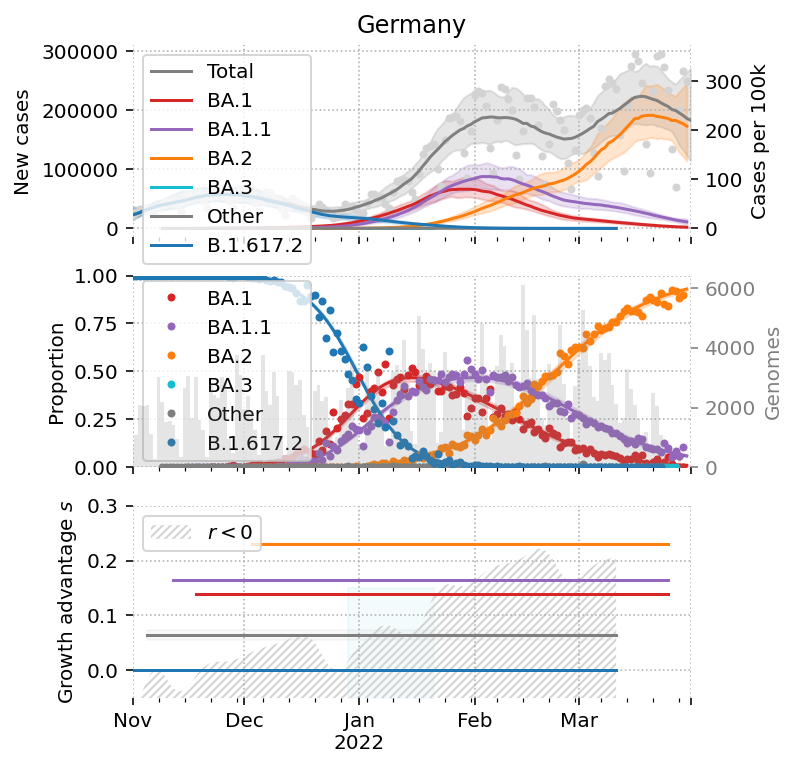

In [49]:
w = np.arange(genomes.shape[-1])
plot_lad(model, -1, 
             #model_uk.cases, model_uk.lineages, np.array([cases_uk.index.to_list().index(i) for i in genomes_uk.index]), 
             start_date="2021-11-01", 
             show_start_date="2021-11-01",
            lin = w,
            labels = genomes.columns[w],
            lin_colors=np.array(['C3','C4', "C1" ,"C9", "C7","C0"])[w],#, "C6", "C1","C8"],
            #labels=[alias(y) if alias(y) != "AY.121" else "Orf3a:202L" for y in x],#["B.1.1.7", 'Delta', "AY.4", 'B.1.617.2.5', "B.1.177"],
            case_color="grey",
            case_markercolor="lightgrey",
                figsize=(5,6),
                prop_err=False,
            clip_to_lineage_data = True,
            bleed_left = 1,
             bleed_right=6,
             show_Rt = False,
             plot_s= True
            )
plt.gcf().get_axes()[2].set_ylim(-0.05,0.3)
plt.gcf().get_axes()[0].set_title("Germany")

In [50]:
λ = model.get_lambda_lineage().mean(0) / model.population[:,np.newaxis, np.newaxis]

In [51]:
λ.shape

(17, 151, 6)

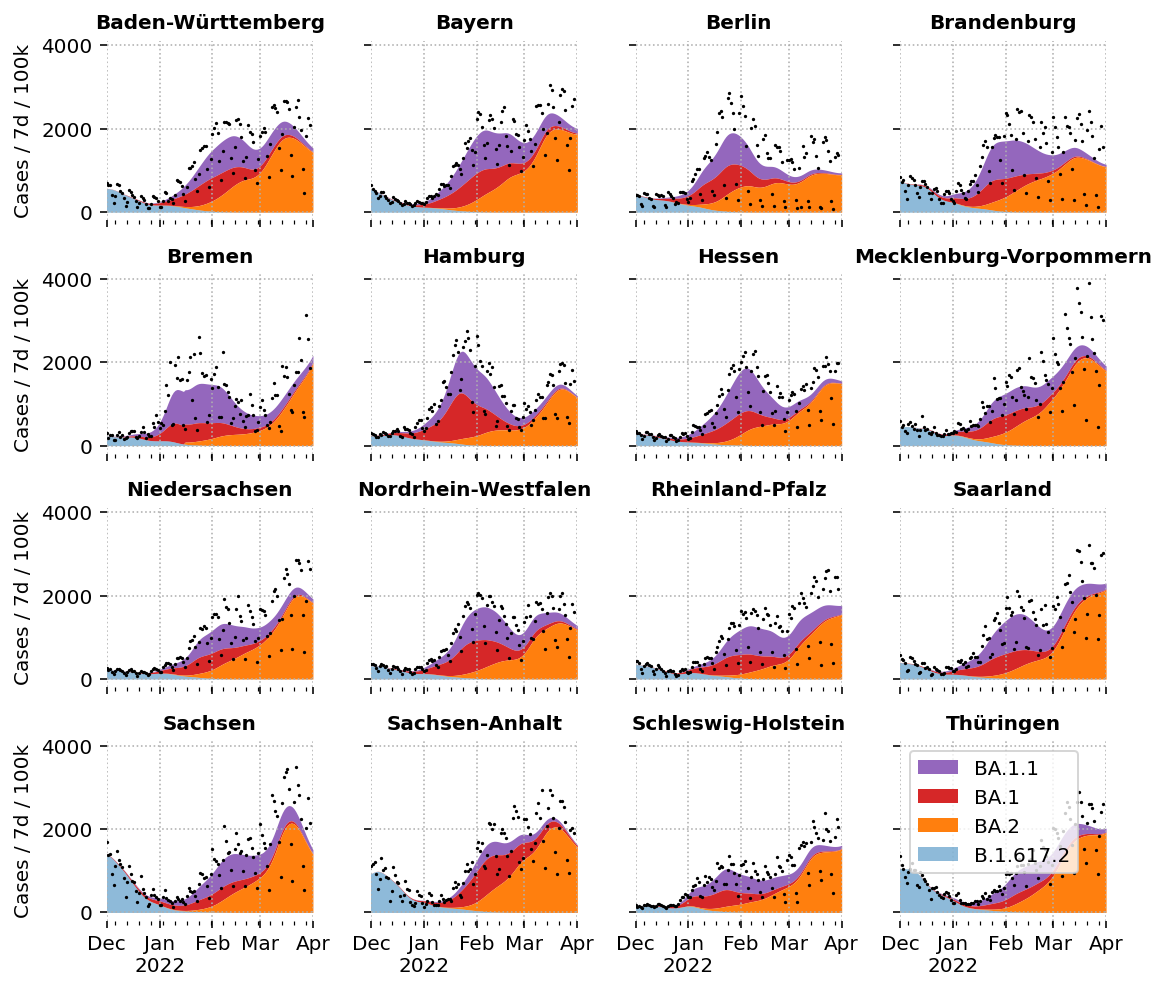

In [52]:
fig, ax = plt.subplots(4,4, figsize=(8,7), sharex=True, sharey=True)
ax = ax.flatten()
for i,r in enumerate(cases_land.index):
    y = pd.DataFrame(λ[i,:,:], columns=genomes.columns, index=cases_land.columns[1] + np.arange(λ.shape[1]).astype('timedelta64[D]')) #cases_land.loc[r].loc["2021-12-01":,'AnzahlFall'] / capita[r] * 1000 #* 700
    y = y[["B.1.617.2","BA.2","BA.1","BA.1.1","BA.3"]].cumsum(1) * 1000 * 700
    #y.index.name = 'date'
    #x = prop_bl.loc[r,:,:][0].unstack()
    #z = x[0.5] * y
    y["BA.1"].plot(ax=ax[i], ls="", label="")
    (cases_land.loc[r]/capita[r]*1000 * 700).plot(ax=ax[i], marker=".", markersize=1.3, color="k", ls="", label="")
    ax[i].fill_between(y.index, y["BA.1"], y["BA.1.1"], color='C4', alpha=1, lw=0, label="BA.1.1")
    ax[i].fill_between(y.index, y["BA.2"], y["BA.1"], color='C3', alpha=1, lw=0, label="BA.1")
    ax[i].fill_between(y.index, y["B.1.617.2"], y["BA.2"], color='C1', alpha=1, lw=0, label="BA.2")
    ax[i].fill_between(y.index, y["B.1.617.2"], color='C0', alpha=.5, lw=0, label="B.1.617.2")
    #ax[i].fill_between(z.index, y-x[0.95]*y, y-x[0.5]*y, color='none',alpha=1, lw=0, label="Omicron", hatch="//////", edgecolor="C3")
    ax[i].set_title(r, size=10 , weight='bold')
    ax[i].set_xlabel(None)
    ax[i].set_ylabel("Cases / 7d / 100k")
    ax[i].grid(ls=":")
    ax[i].set_xlim(("2021-12-01",None))
    for a in ax[i].spines.values():
        a.set_visible(False)
ax[-1].legend(title=None)
plt.tight_layout()
#fig.savefig("plots/omi_abs_by_area.png",dpi=200,bbox_inches='tight',pad_inches=0.2)

In [53]:
λ[-1,-1] / λ[-1,-1].sum()

array([9.93699712e-03, 5.59634207e-02, 9.34092230e-01, 7.02520478e-06,
       2.62920472e-07, 6.44243314e-08])

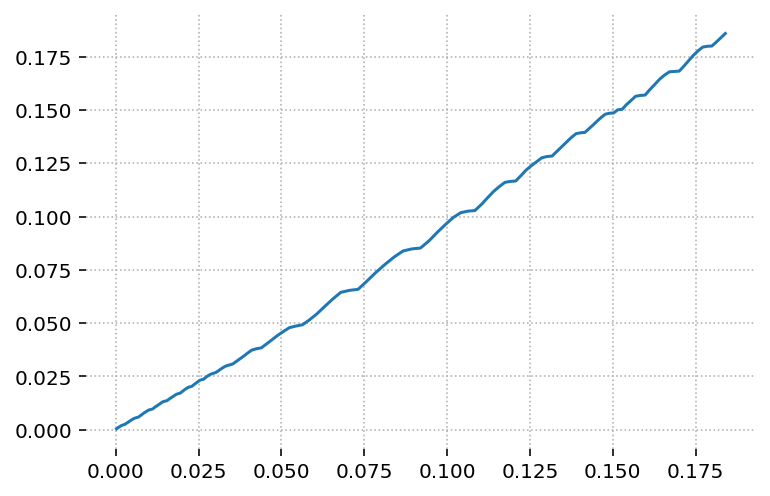

In [54]:
plt.plot(λ[2].sum(1).cumsum()[:-1], cases_land.loc['Berlin'].cumsum() / capita[2])

In [55]:
from genomicsurveillance.misc import get_transmissibility

In [56]:
pd.DataFrame(get_transmissibility(model), columns=genomes.columns, index=cases_land.index.to_list() + ["Germany"])

lineage                     BA.1    BA.1.1      BA.2      BA.3     Other  \
Baden-Württemberg       0.139149  0.168957  0.231245 -0.057760  0.014413   
Bayern                  0.145498  0.164002  0.230742 -0.050980  0.059638   
Berlin                  0.142702  0.167472  0.223721 -0.033101  0.021069   
Brandenburg             0.132922  0.162630  0.230283 -0.056703  0.039568   
Bremen                  0.141494  0.158128  0.227554 -0.033101  0.059623   
Hamburg                 0.124282  0.150945  0.231295 -0.054977  0.060267   
Hessen                  0.129849  0.154693  0.231306 -0.056260  0.018135   
Mecklenburg-Vorpommern  0.140536  0.168783  0.226670 -0.033101  0.039568   
Niedersachsen           0.134062  0.163767  0.231089 -0.033101  0.039592   
Nordrhein-Westfalen     0.137412  0.162754  0.231407 -0.057492  0.044003   
Rheinland-Pfalz         0.125224  0.166389  0.230827 -0.033101  0.016844   
Saarland                0.129153  0.156538  0.231317 -0.033101  0.014926   
Sachsen                 0.139394  0.166910  0.231322 -0.056786  0.064849   
Sachsen-Anhalt          0.145456  0.155706  0.231284 -0.053636  0.039568   
Schleswig-Holstein      0.130771  0.158769  0.222544 -0.057605  0.016857   
Thüringen               0.136058  0.156008  0.231199 -0.033101  0.019494   
Germany                 0.138434  0.163893  0.231057 -0.040450  0.064628   

lineage                 B.1.617.2  
Baden-Württemberg             0.0  
Bayern                        0.0  
Berlin                        0.0  
Brandenburg                   0.0  
Bremen                        0.0  
Hamburg                       0.0  
Hessen                        0.0  
Mecklenburg-Vorpommern        0.0  
Niedersachsen                 0.0  
Nordrhein-Westfalen           0.0  
Rheinland-Pfalz               0.0  
Saarland                      0.0  
Sachsen                       0.0  
Sachsen-Anhalt                0.0  
Schleswig-Holstein            0.0  
Thüringen                     0.0  
Germany                       0.0

n  Growth rate r to ancestor      +/-   \
Lineage                                                  
BA.1       124576                   0.066199  0.006353   
BA.1.1     159128                   0.080183  0.005337   
BA.2       160224                   0.141486  0.002770   
BA.3           92                  -0.033101  0.046612   
Other         630                   0.039568  0.020886   
B.1.617.2  237874                   0.000000  0.000000   

           Growth rate r to baseline BA.1       +/-  
Lineage                                              
BA.1                             0.000000  0.006353  
BA.1.1                           0.025526  0.005337  
BA.2                             0.093675  0.002770  
BA.3                            -0.190288  0.046612  
Other                           -0.099285  0.020886  
B.1.617.2                       -0.136023  0.000000

/Users/mg14/Git/desh-data/genomicsurveillance/misc/misc.py:917: RuntimeWarning: divide by zero encountered in log
  ax3 = plt.gca().secondary_yaxis('right', functions=(lambda x: np.exp(x*model.tau), lambda x: np.log(x)/model.tau))


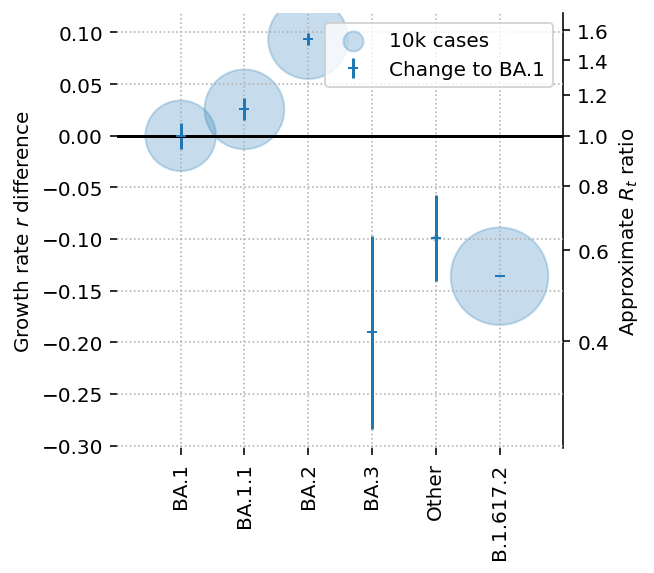

In [57]:
plt.figure(figsize=(4,4))
plot_growth_rates(model, genomes.columns.to_list(), color=["C0","None"], baseline="BA.1")

In [58]:
import geopandas as gpd

In [59]:
bl = gpd.read_file("data/bundeslaender.geojson").set_index("bundesland")

In [60]:
bl

land  \
bundesland                            
Baden-Württemberg       Deutschland   
Bayern                  Deutschland   
Berlin                  Deutschland   
Brandenburg             Deutschland   
Bremen                  Deutschland   
Hamburg                 Deutschland   
Hessen                  Deutschland   
Mecklenburg-Vorpommern  Deutschland   
Niedersachsen           Deutschland   
Nordrhein-Westfalen     Deutschland   
Rheinland-Pfalz         Deutschland   
Saarland                Deutschland   
Sachsen                 Deutschland   
Sachsen-Anhalt          Deutschland   
Schleswig-Holstein      Deutschland   
Thüringen               Deutschland   

                                                                 geometry  
bundesland                                                                 
Baden-Württemberg       MULTIPOLYGON (((7.63396 47.56122, 7.68592 47.5...  
Bayern                  MULTIPOLYGON (((9.63623 47.60202, 9.74582 47.6...  
Berlin                  POLYGON ((13.73143 52.41981, 13.73412 52.40198...  
Brandenburg             POLYGON ((14.03274 51.47500, 14.06259 51.44542...  
Bremen                  MULTIPOLYGON (((8.96595 53.05772, 8.98022 53.0...  
Hamburg                 MULTIPOLYGON (((10.21828 53.49923, 10.26573 53...  
Hessen                  MULTIPOLYGON (((8.90009 49.48187, 8.89974 49.5...  
Mecklenburg-Vorpommern  MULTIPOLYGON (((11.52874 54.07105, 11.51283 54...  
Niedersachsen           MULTIPOLYGON (((10.36397 51.55606, 10.36689 51...  
Nordrhein-Westfalen     MULTIPOLYGON (((6.16603 50.66186, 6.19337 50.6...  
Rheinland-Pfalz         POLYGON ((8.28766 48.99838, 8.23545 48.96749, ...  
Saarland                POLYGON ((7.31027 49.12958, 7.29356 49.11499, ...  
Sachsen                 POLYGON ((12.23908 50.24698, 12.26616 50.25888...  
Sachsen-Anhalt          POLYGON ((12.19559 51.14146, 12.24134 51.13061...  
Schleswig-Holstein      MULTIPOLYGON (((11.00454 54.45007, 11.01815 54...  
Thüringen               POLYGON ((10.59094 50.27180, 10.60497 50.29310...

In [61]:
λ.sum(0)[-1] / λ.sum((0,2))[-1]

array([8.94697763e-03, 5.53511630e-02, 9.30272950e-01, 5.42628081e-03,
       2.53438038e-06, 9.45647933e-08])

In [62]:
de = bl.copy()
de.geometry = de.buffer(1e-2)
de = de.dissolve(by='land')

/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  


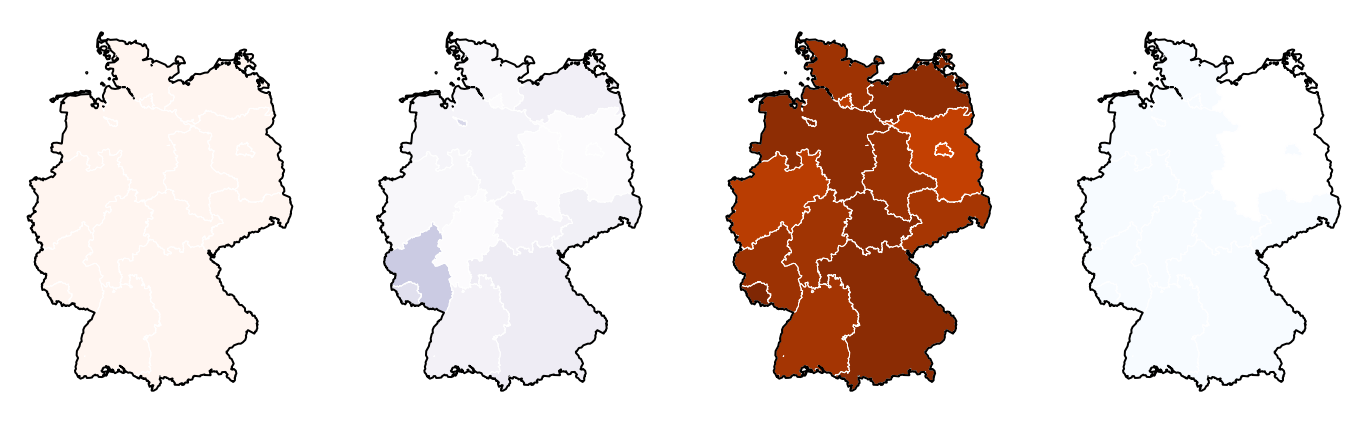

In [63]:
from matplotlib.colors import LogNorm
fig, axs = plt.subplots(1,4, figsize=(12,6))
for ax in axs:
    ax.axis("off")
#camera = Camera(fig)
vmax = λ[:-1,-1,:].max()
vmin = 1e-4
b0 = bl.copy().merge(pd.DataFrame(λ[:-1,-1,:], columns=genomes.columns, index=bl.index), 
                     left_index=True, right_index=True)
b0.plot("BA.1", ax=axs[0], cmap="Reds", norm=LogNorm(vmin=vmin, vmax=vmax))
b0.plot("BA.1.1", ax=axs[1], cmap="Purples", norm=LogNorm(vmin=vmin, vmax=vmax))
b0.plot("BA.2", ax=axs[2], cmap="Oranges",norm=LogNorm(vmin=vmin, vmax=vmax))
b0.plot("Other", ax=axs[3], cmap="Blues",norm=LogNorm(vmin=vmin, vmax=vmax))
for ax in axs:
    bl.boundary.plot(color='w',lw=0.5, ax=ax)
    de.boundary.plot(color='k',lw=1, ax=ax)

In [64]:
b0.iloc[:,2:] * capita.values.reshape(-1,1)

BA.1       BA.1.1          BA.2         BA.3  \
bundesland                                                                   
Baden-Württemberg       219.587013  1503.114929  22733.293942     0.000427   
Bayern                  493.395998  2093.947118  35123.457273    14.537137   
Berlin                   33.947385   193.105088   4710.812995     0.000000   
Brandenburg              16.030556   186.377217   3951.724267     0.390161   
Bremen                   26.474583   166.348993   1912.380519     0.000000   
Hamburg                  17.746993    98.000467   3046.306852     0.005700   
Hessen                   64.385308   541.083168  13386.844407     0.811295   
Mecklenburg-Vorpommern   36.169038   233.240585   4125.441653     0.000000   
Niedersachsen           128.857550  1006.603223  20837.770674     0.000000   
Nordrhein-Westfalen     443.368529  2076.152925  30331.218768  3608.363064   
Rheinland-Pfalz          83.525977  1202.117996   9052.153714     0.000000   
Saarland                 23.425911   201.683189   3011.359032     0.000000   
Sachsen                  67.333608   581.899839   8065.729282    64.763500   
Sachsen-Anhalt          105.774437    70.997992   4887.051293     0.068568   
Schleswig-Holstein       38.507712   322.051616   6336.186534     0.009102   
Thüringen                44.653731   277.207806   5801.958188     0.000000   

                           Other  B.1.617.2  
bundesland                                   
Baden-Württemberg       0.002754   0.002283  
Bayern                  0.007096   0.001641  
Berlin                  0.000808   0.000069  
Brandenburg             0.000000   0.000223  
Bremen                  0.001140   0.000048  
Hamburg                 0.000769   0.000131  
Hessen                  0.588012   0.000477  
Mecklenburg-Vorpommern  0.000000   0.000475  
Niedersachsen           0.002251   0.001690  
Nordrhein-Westfalen     0.001025   0.002359  
Rheinland-Pfalz         0.001339   0.002248  
Saarland                0.001158   0.000293  
Sachsen                 0.001386   0.000445  
Sachsen-Anhalt          0.000000   0.001127  
Schleswig-Holstein      0.001271   0.000256  
Thüringen               0.005100   0.001729

In [65]:
r = model.get_growth_rate_lineage(ltla=None).mean(0)[:,-5,:]
r

array([[-1.17073431e-01, -8.72409463e-02, -2.49905770e-02,
        -3.33996603e-01, -2.40221833e-01, -2.56206262e-01],
       [-9.53045288e-02, -7.66980709e-02, -1.01037425e-02,
        -4.51850657e-01, -1.81135403e-01, -2.40760578e-01],
       [-8.50041977e-02, -6.02728009e-02, -4.07334947e-03,
        -2.27750612e-01, -2.02436696e-01, -2.27750612e-01],
       [-1.11172666e-01, -8.15255004e-02, -1.39356918e-02,
        -3.03596317e-01, -2.44137866e-01, -2.44137866e-01],
       [-5.44851079e-02, -3.83661998e-02,  3.11813242e-02,
        -1.96419871e-01, -1.40428822e-01, -1.96419871e-01],
       [-1.44524835e-01, -1.17987621e-01, -3.75336103e-02,
        -3.45094824e-01, -2.08678367e-01, -2.68897737e-01],
       [-1.17924524e-01, -9.33053921e-02, -1.65491929e-02,
        -3.16804863e-01, -2.15071610e-01, -2.47860992e-01],
       [-1.08861593e-01, -8.06443087e-02, -2.28301704e-02,
        -2.49512284e-01, -2.49512284e-01, -2.49512284e-01],
       [-1.23489015e-01, -9.37075788e-02, -2.636

/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/geopandas/plotting.py:376: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/geopandas/plotting.py:376: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/geopandas/plotting.py:376: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/geopandas/plotting.py:376: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,


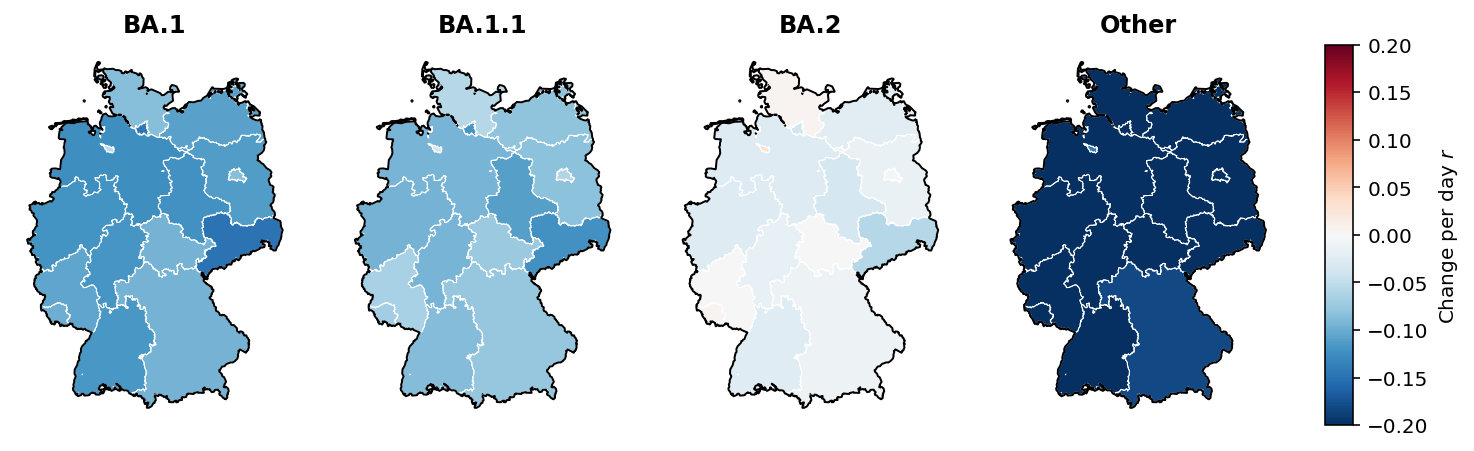

In [66]:
from matplotlib.colors import LogNorm
fig, axs = plt.subplots(1,5, figsize=(12,3.5), gridspec_kw={'width_ratios': [1, 1,1,1,0.1]})
for ax in axs[:-1]:
    ax.axis("off")
#camera = Camera(fig)
vmax = λ[:-1,-1,:].max()
vmin = 1e-4
d = pd.DataFrame(r[:-1,:], columns=genomes.columns, index=bl.index)
#d.loc["Sachsen-Anhalt"]=np.nan
b0 = bl.copy().merge(d, 
                     left_index=True, right_index=True)
b0.plot("BA.1", ax=axs[0], cmap="RdBu_r", vmin=-0.2,vmax=0.2, cax=axs[4], legend_kwds={'label': "Change per day $r$", 'pad':0.3}, legend=True, missing_kwds= dict(color = "lightgrey"))# norm=LogNorm(vmin=vmin, vmax=vmax))
b0.plot("BA.1.1", ax=axs[1], cmap="RdBu_r", vmin=-0.2,vmax=0.2,missing_kwds= dict(color = "lightgrey"))#, norm=LogNorm(vmin=vmin, vmax=vmax))
b0.plot("BA.2", ax=axs[2], cmap="RdBu_r", vmin=-0.2,vmax=0.2,missing_kwds= dict(color = "lightgrey"))#,norm=LogNorm(vmin=vmin, vmax=vmax))
b0.plot("Other", ax=axs[3], cmap="RdBu_r", vmin=-0.2,vmax=0.2,missing_kwds= dict(color = "lightgrey"))#,norm=LogNorm(vmin=vmin, vmax=vmax))
for i,ax in enumerate(axs[:-1]):
    ax.set_title(genomes.columns[[0,1,2,4]][i], weight='bold')
    bl.boundary.plot(color='w',lw=0.5, ax=ax)
    de.boundary.plot(color='k',lw=1, ax=ax)

In [67]:
from sklearn.linear_model import LinearRegression as LR
from adjustText import adjust_text
import re

In [68]:
j

24

0.07069868281110661
0.08626862616509487
0.04385605918808592
0.042607422277869476


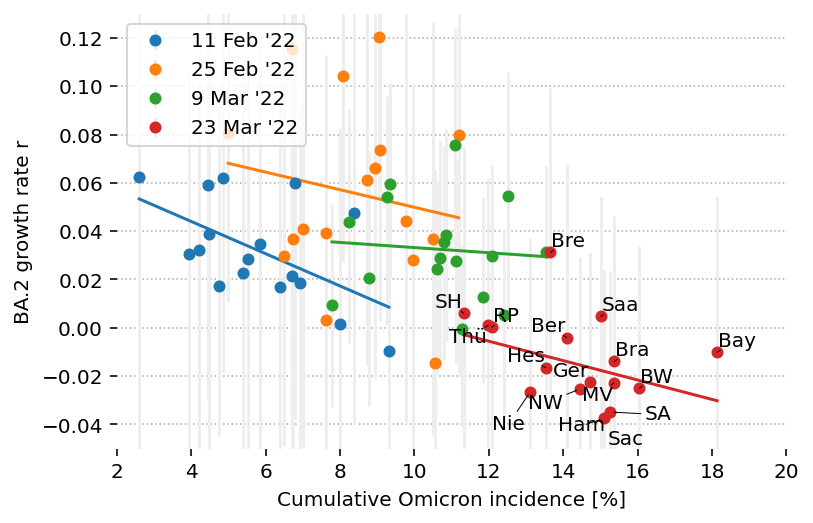

In [80]:
fig, axs = plt.subplots(1,1, figsize=(6,4), sharey=True)
#axs = axs.flatten()
text=[]
for k,l in enumerate(["2022-02-11", "2022-02-25","2022-03-09","2022-03-23"]):
    j = np.where(cases_land.columns == l)[0][0]
    ax = axs#[0]
    ci = np.quantile(model.get_growth_rate_lineage(ltla=None)[:,:,j,2], (0.1, 0.9), axis=0)
    r = model.get_growth_rate_lineage(ltla=None).mean(0)[:,j,:]

    lr = LR()
    x = λ[...,:j,:3].sum((1,2)) * 100
    y = r[:,2]
    lr.fit(x[:,np.newaxis], y)
    ax.errorbar(x, y, yerr=np.abs(ci - y[np.newaxis,:]), ls="", marker=".", ms=10,color=f'C{k}', ecolor='#EEEEEE', 
               label=cases_land.columns[j].strftime("%-d %b \'%y"))
    #ax.set_title(cases_land.columns[j].strftime("%-d %b \'%y"))

    l=[re.sub("[a-zöüä\-]","",x) if re.search("-",x) else x[:3] for x in (cases_land.index.to_list() + ['Germany'])]
    
    for i in range(x.shape[0]):
        if k==3:#l[i]#in ["BW","NW","RP","Saa"]:
            text.append(ax.text(x[i], y[i], l[i], color='k', va='bottom', ha='center'))
    x.sort()
    y = lr.predict(x[:,np.newaxis])
    line = ax.plot(x, y, ls="-", c=f'C{k}')
    #plt.axline((0, lr.intercept_), slope=lr.coef_)
    #plt.scatter(λ[...,:2].sum((1,2)), r[:,2])
    ax.set_xlabel("Cumulative Omicron incidence [%]")
    if k == 0: 
        ax.set_ylabel("BA.2 growth rate r") 
    ax.set_ylim((-0.05,0.13))
    ax.set_xlim((2,20))
    print(lr.intercept_)

adjust_text(text, 
                #add_objects=line, 
                #expand_objects = (1,1),
                #force_objects =  (0, 0.2),
                #only_move=dict(objects='y', text='y', points='y'),
                arrowprops=dict(arrowstyle="-", color='k', lw=0.5), )
ax.grid(axis='x', which='major')
ax.legend(loc='upper left')


In [70]:
λ[-1,-1,2]/ λ[-1,-1,:].sum()

0.9340922296138215

In [71]:
d = pd.DataFrame(model.get_growth_rate_lineage(ltla=None).mean(0)[:,[-24,-10],2], index=cases_land.index.to_list() + ["Germany"], columns=cases_land.columns[[-24,-10]])

<AxesSubplot:>

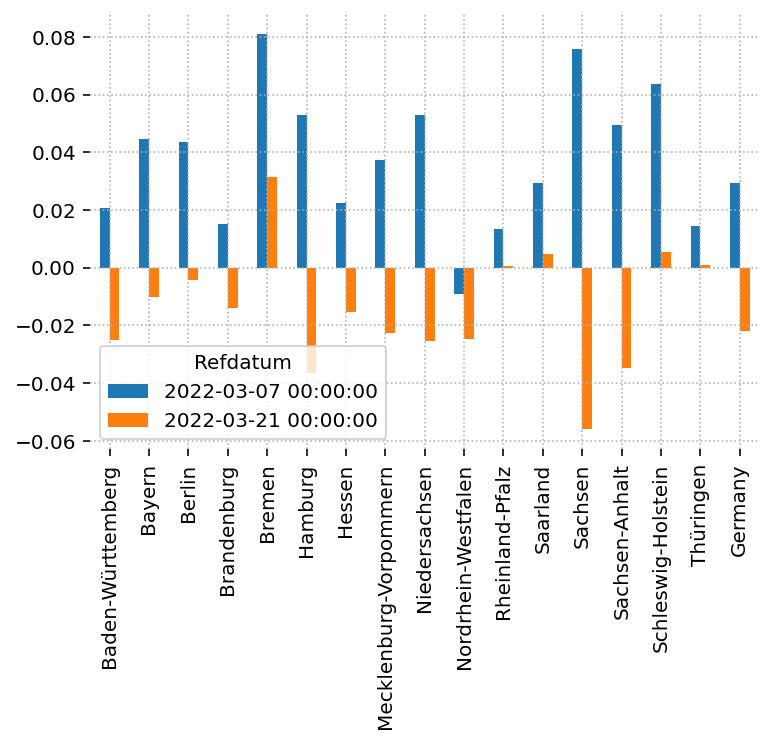

In [72]:
d.plot.bar()

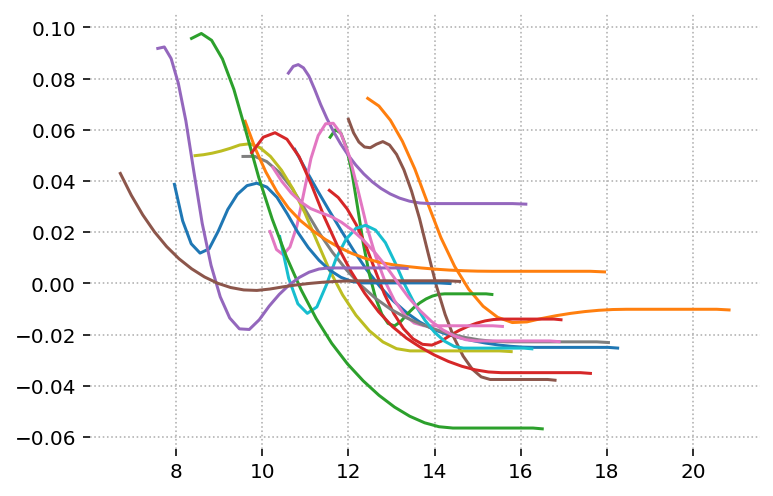

In [73]:
r = model.get_growth_rate_lineage(ltla=None).mean(0)[:,-28:,2]
x = λ[...,:,:3].sum(2).cumsum(1)[:,-28:] * 100
for i in range(r.shape[0]):
    plt.plot(x[i,:],r[i,:])

(18962.0, 19077.0)

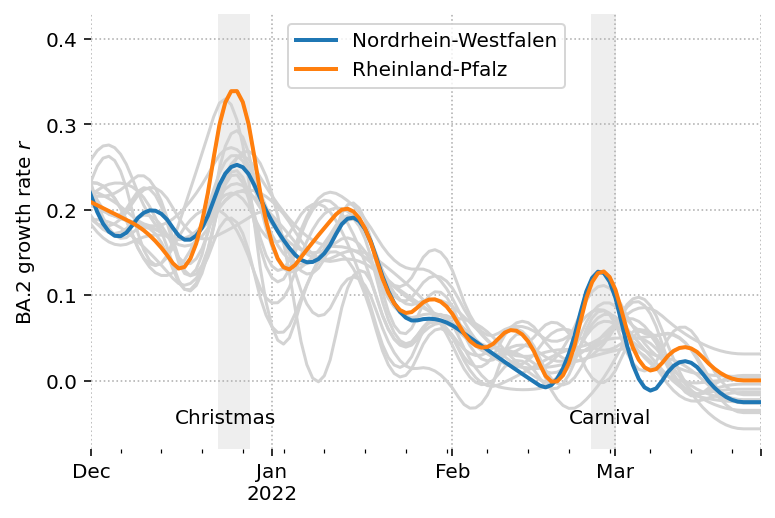

In [74]:
r = np.mean(model.get_growth_rate_lineage(ltla=None),0)[:,:,2]
r = pd.DataFrame(r.T[:-5], index=cases_land.columns[:-4].to_list(), columns=cases_land.index.to_list() + ["Germany"])
r.plot(c = 'lightgrey', alpha=1, legend=False)
r[["Nordrhein-Westfalen","Rheinland-Pfalz"]].plot( alpha=1, lw=2, ax=plt.gca())
#plt.legend("off")
plt.ylabel("BA.2 growth rate $r$")
plt.axvspan("2021-12-23","2021-12-28", color='#EEEEEE', zorder=0)
plt.axvspan("2022-02-25","2022-03-01", color='#EEEEEE', zorder=0)
plt.text("2021-12-24",-0.05,"Christmas", ha='center')
plt.text("2022-02-28",-0.05,"Carnival", ha='center')
plt.xlim(("2021-12-01",None))

In [64]:
from celluloid import Camera
from tqdm import tqdm
from matplotlib import colors


100%|██████████| 122/122 [00:42<00:00,  2.87it/s]


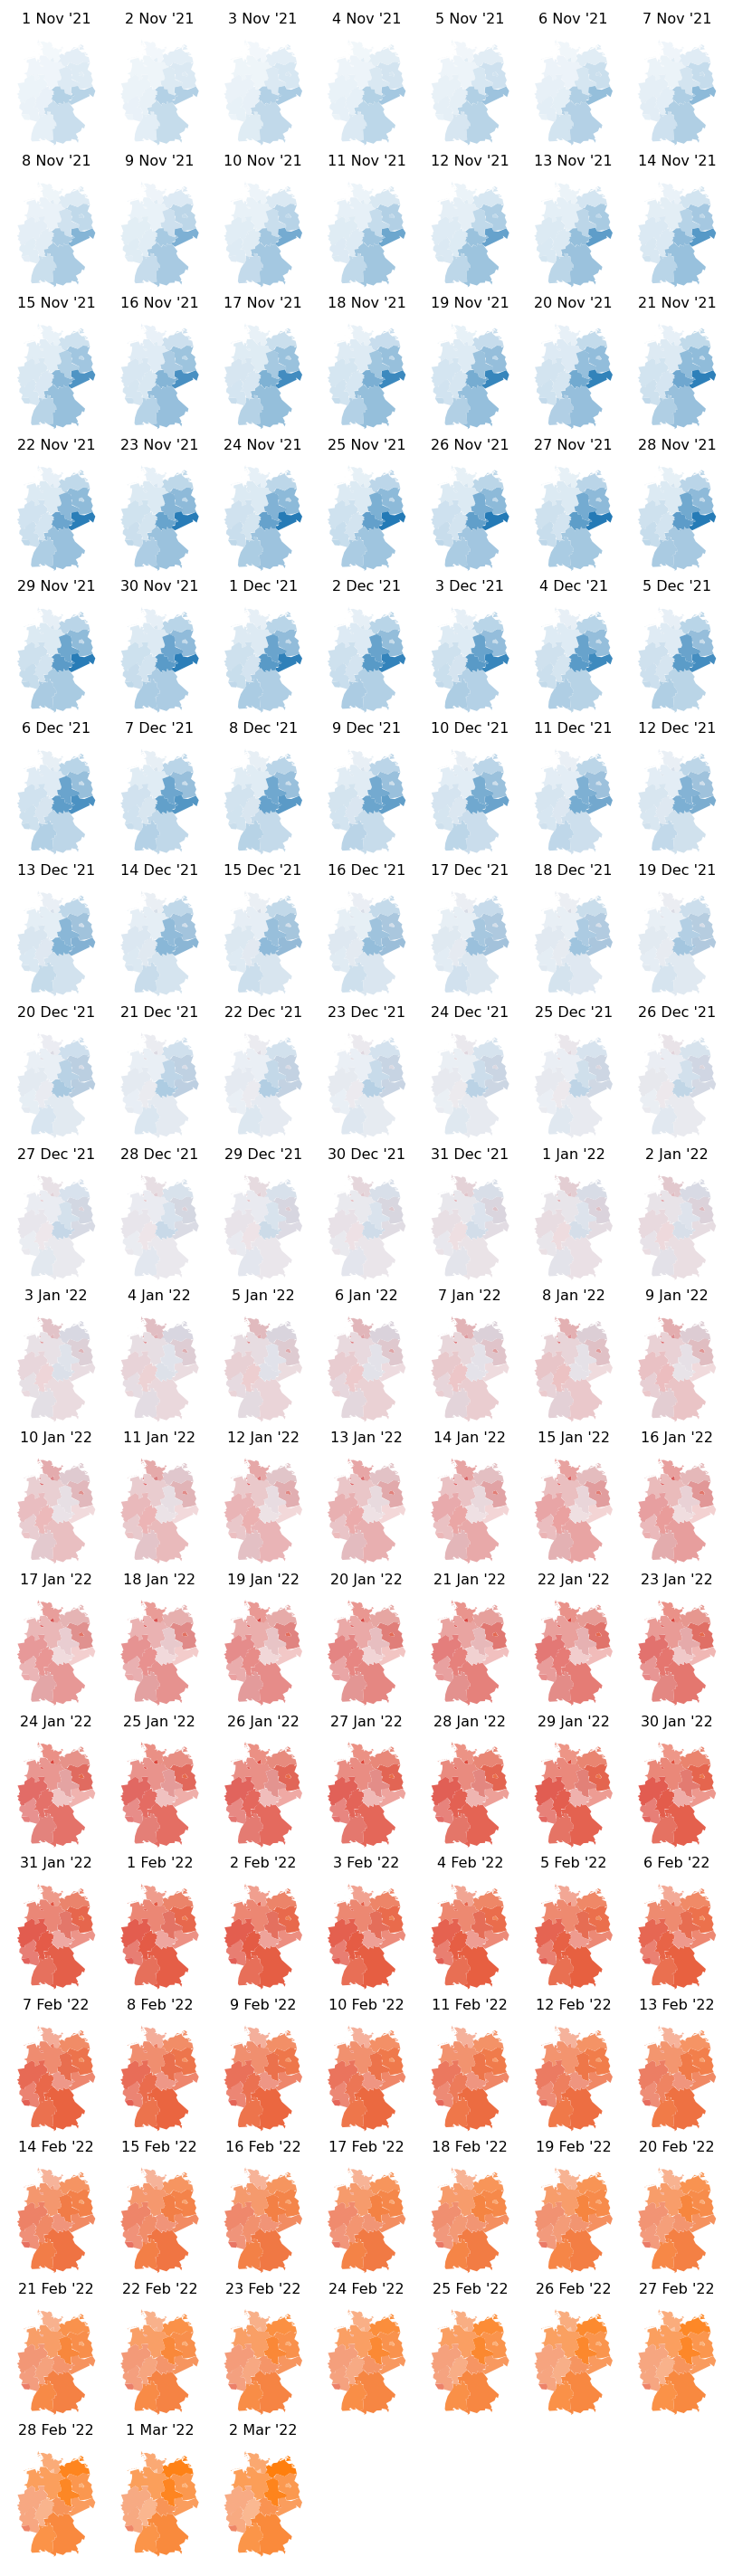

In [65]:
n = 7
m = (int(λ.shape[1]/7)+1)
fig, axs = plt.subplots(m,n, figsize=(7,10*m/n))
#camera = Camera(fig)
b0 = bl.copy().simplify(1e-1)
axs = axs.flatten()
for ax in axs:
    ax.axis("off")

    
def make_rgb_transparent(rgb, bg_rgb, alpha):
    return [alpha * c1 + (1 - alpha) * c2 for (c1, c2) in zip(rgb, bg_rgb)]

def alpha_to_color(alpha, c):
    c0 = []#(1,1,1)
    for x in alpha:
        cc = (1,1,1)
        for j, y in enumerate(x):
            cc = make_rgb_transparent(c[j ], cc, y)
        c0 += [cc]
    return c0

cols = [colors.colorConverter.to_rgb("C3"),
     colors.colorConverter.to_rgb("C3"),
     colors.colorConverter.to_rgb("C1"),
     colors.colorConverter.to_rgb("C0")]

for i in tqdm(range(λ.shape[1])): #λ.shape[1])
    ax = axs[i]
        
    #alpha = np.minimum(1, λ[:-1,i,[1,4]] * 700) #/λ.max()

    alpha = λ[:-1,i,[0,1,2,-1]]/λ.max()
    c = alpha_to_color(alpha, cols)

    ax.set_title((cases_land.columns[0] + np.timedelta64(i,"D")).strftime("%-d %b \'%y"), size=8)
    b0.plot(color=c, ax=ax)

    #bl.boundary.plot(color='w',lw=0.5, ax=ax)
    #de.boundary.plot(color='k',lw=1, ax=ax)
    #camera.snap()


In [66]:
f"{λ[:-1,-1,1] @ capita.values:0.0f}"

'37221'

In [67]:
λ.max()*700

1.4526477300739673

100%|██████████| 122/122 [07:36<00:00,  3.74s/it]


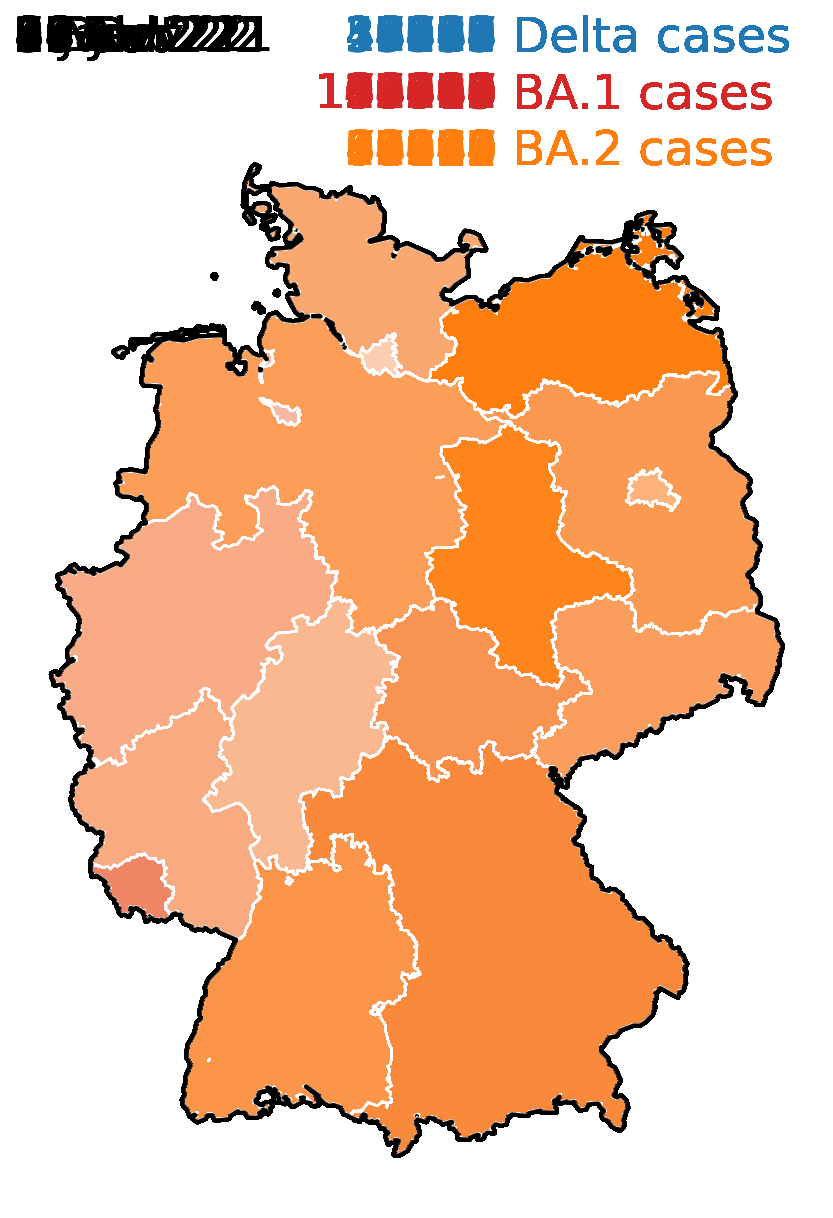

In [68]:
fig, ax = plt.subplots(1,1, figsize=(8,10.5), facecolor=None)
camera = Camera(fig)
b0 = bl.copy()#.simplify(1e-2)

ax.axis("off")

for i in tqdm(range(λ.shape[1])): #λ.shape[1])
    
    #alpha = np.minimum(1, λ[:-1,i,[1,4]] * 700) #/λ.max()
    alpha = λ[:-1,i,[0,1,2,-1]]/λ.max()
    c = alpha_to_color(alpha, cols)
    #c = [make_rgb_transparent(y, make_rgb_transparent(r, make_rgb_transparent(b, (1,1,1), x[2]), x[0]), x[1]) for x in alpha]
    b0.plot(color=c, ax=ax)

    #ax.set_title(cases_land.columns[i].strftime("%-d %b \'%y"), size=12)
    if i == 0:
        ax.set_ylim((None, ax.get_ylim()[0] + 1.05 * (ax.get_ylim()[1]-ax.get_ylim()[0])))
    
    ax.text(0.0, 1.01,  (cases_land.columns[0] + np.timedelta64(i,"D")).strftime("%-d %b \'%y"), size=24, transform=ax.transAxes)
    ax.text(0.6, 1.01,  f"{λ[:-1,i,-1] @ capita.values:0.0f}", color = "C0", size=24, transform=ax.transAxes, ha = 'right')
    ax.text(0.6, 0.96,  f"{λ[:-1,i,[0,1]].sum(-1) @ capita.values:0.0f}", color = "C3", size=24, transform=ax.transAxes, ha= 'right')
    ax.text(0.6, 0.91,  f"{λ[:-1,i,2] @ capita.values:0.0f}", color = "C1", size=24, transform=ax.transAxes, ha = 'right')
    ax.text(0.6, 1.01,  f" Delta cases", color = "C0", size=24, transform=ax.transAxes)
    ax.text(0.6, 0.96,  f" BA.1 cases", color = "C3", size=24, transform=ax.transAxes)
    ax.text(0.6, 0.91,  f" BA.2 cases", color = "C1", size=24, transform=ax.transAxes)

    bl.boundary.plot(color='w',lw=1, ax=ax)
    de.boundary.plot(color='k',lw=2, ax=ax)
    camera.snap()


In [69]:
animation = camera.animate(interval = 100, blit=True, repeat = False, repeat_delay=1000)

In [70]:
#import ffmpeg
from IPython.display import HTML
import re
HTML(re.sub("width=\"576\"","width=288",animation.to_html5_video()))

# UK analysis

In [209]:
import requests
cases_uk = pd.read_csv("https://api.coronavirus.data.gov.uk/v2/data?areaType=overview&metric=newCasesBySpecimenDate&format=csv", parse_dates=True, index_col=3)["newCasesBySpecimenDate"].sort_index().loc["2021-11-01":].iloc[:-1]

In [210]:
cases_uk

date
2021-11-01    45069
2021-11-02    37976
2021-11-03    35934
2021-11-04    33616
2021-11-05    30295
              ...  
2022-02-17    43559
2022-02-18    32333
2022-02-19    33861
2022-02-20    36757
2022-02-21    42078
Name: newCasesBySpecimenDate, Length: 113, dtype: int64

In [211]:
x = []
c = "United Kingdom"
for v in ['BA.1','BA.1.1', 'BA.2', 'BA.3', 'B.1.617.2*']:
    r = requests.get(f"https://lapis.cov-spectrum.org/gisaid/v1/sample/aggregated?fields=date&host=Human&country={c}&dateFrom=2021-11-01&dateTo={np.datetime64('today')}&pangoLineage={v}") #&dataVersion=1642092398
    d = pd.DataFrame(r.json()['data'])
    x.append(pd.DataFrame({v: d['count'].values}, index=pd.DatetimeIndex(d.date)).sort_index()[v])

genomes_uk = pd.DataFrame(x).T.fillna(0)#
genomes_uk = genomes_uk.loc[genomes_uk.index <= cases_uk.index.max(),:]
genomes_uk.sum(0)

BA.1          338473.0
BA.1.1        138324.0
BA.2           29613.0
BA.3              18.0
B.1.617.2*    372938.0
dtype: float64

In [212]:
genomes_uk = genomes_uk[genomes_uk.sum(1) > 100]

In [213]:
genomes_uk

BA.1  BA.1.1    BA.2  BA.3  B.1.617.2*
date                                                
2021-11-01     0.0     0.0     0.0   0.0      7781.0
2021-11-02     0.0     0.0     0.0   0.0      5999.0
2021-11-03     1.0     0.0     0.0   0.0      7031.0
2021-11-04     0.0     0.0     0.0   0.0      6415.0
2021-11-05     0.0     0.0     0.0   0.0      7034.0
...            ...     ...     ...   ...         ...
2022-02-12  1279.0  1889.0  1444.0   1.0         1.0
2022-02-13   635.0   983.0   856.0   0.0         1.0
2022-02-14   764.0  1270.0  1026.0   0.0         0.0
2022-02-15   368.0   617.0   593.0   0.0         1.0
2022-02-16    30.0    57.0    72.0   0.0         0.0

[108 rows x 5 columns]

In [214]:
genomes_uk["BA.1"][:"2021-11-18"] = 0
genomes_uk["BA.1.1"][:"2021-11-18"] = 0
genomes_uk["BA.2"][:"2021-12-18"] = 0

In [ ]:
date_split = np.datetime64("2021-12-14") + np.arange(0,8,2).astype("timedelta64[W]")#[np.datetime64("2021-12-12"), np.datetime64("2021-12-31")]
#bar[1,genomes_uk.index > d[1],:] = 0
#bar[2,genomes_uk.index <= d[1],:] = 0

In [216]:
date_split

array(['2021-12-14', '2021-12-28', '2022-01-11', '2022-01-25'],
      dtype='datetime64[D]')

In [217]:
foo = np.stack((len(date_split)+1) * [cases_uk["2021-11-01":].values], axis=0)
bar = np.stack((len(date_split)+1)  * [genomes_uk.values], axis=0)
for i, dd in enumerate(date_split):
    bar[i,genomes_uk.index > dd,:] = 0
    bar[i+1,genomes_uk.index <= dd,:] = 0


In [218]:
model_uk = MultiLineageTimeShift(
    foo, #cases_uk["2021-11-01":].values.reshape(1,-1),
    bar,    
    np.array([cases_uk.index.to_list().index(i) for i in genomes_uk.index]),
    np.repeat(67.22e6,len(date_split)+1),
    #auto_correlation=0.5,
    #linearize=True,
    arma = arma2,
    b_scale=0.05,
    b0_scale=0.5,
    c_scale=10.,
    beta_scale= np.append(10.,np.repeat(10., B0.shape[2]-1)),# np.concatenate([np.repeat(1., knots.num_long_basis), np.repeat(.1, knots.num_short_basis)]),
    tau=4.6,
    basis=B0, #knots.basis,
    shift=7,  
    alpha0=.01,
    alpha1=10000., 
    week=True,
    #model_kwargs={'handler':'SVI', 'loss':Trace_ELBO(num_particles=5), 'num_epochs':10000, 'lr':0.001, 'num_samples': 100}
    model_kwargs={'handler':'SVI', 'loss':Trace_ELBO(num_particles=10), 'num_epochs':10000, 'lr':0.005, 'lrd': 0.1 ** (1/10000), 'num_samples': 100}

)

In [219]:
model_uk.fit()

/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/jax/_src/numpy/lax_numpy.py:6576: UserWarning: Explicitly requested dtype float requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


KeyboardInterrupt: 

In [ ]:
plt.plot(model_uk.loss[2000:])
plt.xlabel('Epoch')
plt.ylabel('ELBO')

In [ ]:
import importlib
importlib.reload(gs.misc.misc)
importlib.reload(gs.misc)
from genomicsurveillance.misc import MultiLineageTimeShift, plot_lad, plot_growth_rates, get_transmissibility

In [ ]:
for j,i in enumerate(range(bar.shape[0]-1,-1, -1)):
    w = [0,1,2,4]#np.arange(genomes_uk.shape[1]) #if i == 2 else [0,2]
    plot_lad(model_uk, i, 
             #model_uk.cases, model_uk.lineages, np.array([cases_uk.index.to_list().index(i) for i in genomes_uk.index]), 
             start_date="2021-11-01", 
             show_start_date="2021-11-01",
            lin = w,
            labels = genomes_uk.columns[w],
            lin_colors=np.array(['C3','C4', "C1" ,"C9", "C0","C0"])[w],#, "C6", "C1","C8"],
            #labels=[alias(y) if alias(y) != "AY.121" else "Orf3a:202L" for y in x],#["B.1.1.7", 'Delta', "AY.4", 'B.1.617.2.5', "B.1.177"],
            case_color="grey",
            case_markercolor="lightgrey",
                figsize=(5,6),
                prop_err=False,
            clip_to_lineage_data = True,
             add = j,
            bleed_left = 1,
             bleed_right= 5 if j == 0 else 1,
             show_Rt = False,
             plot_s= True,
             plot_r = True
            )

ax=plt.gcf().get_axes()
    
ax[0].set_title("United Kingdom", size=12, weight='bold')
#ax[0].set_yscale("log")

ax[1].set_yscale("logit")
ax[1].set_ylim((1e-4,1-1e-2))
ax[2].set_ylim((-.2,.45))
ax[1].legend(facecolor='white')
#ax[2].legend().remove()
ax[2].legend(loc='lower left')
ax[3].grid(False)
for i,a in enumerate(ax[:-1]):
    a.grid(ls=":")
    for dd in date_split:
        x = dd 
        if i ==2:
            x -= np.timedelta64(int(model.tau), "D")
            a.axvline(x, ls=":", color='k', lw=0.5)
#f = ax[2].xaxis.get_major_formatter()
#ax[1].xaxis.set_major_formatter(f)
#ax[1].set_xticklabels(ax[2].get_xticklabels(), visible=True)
#plt.setp(ax[1].get_xticklabels(),visible=True)
#plt.delaxes(ax[3])
#plt.delaxes(ax[0])
#ax[1].xaxis.set_tick_params(labelbottom=True)

#ax[1].xaxis.set_major_formatter(f)


In [ ]:
## import importlib
importlib.reload(gs.misc.misc)
importlib.reload(gs.misc)
from genomicsurveillance.misc import MultiLineageTimeShift, plot_lad, plot_growth_rates

In [ ]:
plt.figure(figsize=(4,4))
plot_growth_rates(model_uk, genomes_uk.columns.to_list(), color=["C0","None"], baseline="BA.1")


In [ ]:
bar.shape

In [ ]:
ax=plt.gcf().get_axes()

In [ ]:
ax

## Germany

In [358]:
foo = np.stack((len(date_split)+1) * [CC[-1]], axis=0)
bar = np.stack((len(date_split)+1)  * [GG[-1]], axis=0)
for i, dd in enumerate(date_split):
    bar[i,genomes.index.levels[1] > dd + np.timedelta64(2,"D"),:] = 0
    bar[i+1,genomes.index.levels[1] < dd - np.timedelta64(1,"D"),:] = 0
bar[0,:,2] = 0

In [359]:
model_de = MultiLineageTimeShift(
    foo, #cases_uk["2021-11-01":].values.reshape(1,-1),
    bar,    
    seq_index,
    np.repeat(capita.values.sum().reshape(1),len(date_split)+1),
    #auto_correlation=0.5,
    #linearize=True,
    arma = arma2,
    b_scale=0.05,
    b0_scale=0.5,
    c_scale=5,
    beta_scale= np.append(10.,np.repeat(10., B0.shape[2]-1)),# np.concatenate([np.repeat(1., knots.num_long_basis), np.repeat(.1, knots.num_short_basis)]),
    tau=4.6,
    basis=B0, #knots.basis,
    shift=7,  
    alpha0=.01,
    alpha1=10000., 
    week=True,
    #model_kwargs={'handler':'SVI', 'loss':Trace_ELBO(num_particles=5), 'num_epochs':10000, 'lr':0.001, 'num_samples': 100}
    model_kwargs={'handler':'SVI', 'loss':Trace_ELBO(num_particles=10), 'num_epochs':10000, 'lr':0.005, 'lrd': 0.1 ** (1/10000), 'num_samples': 100}

)

In [360]:
model_de.fit()

/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/jax/_src/numpy/lax_numpy.py:6576: UserWarning: Explicitly requested dtype float requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


SVI step 0 / 10,000 | 0 %
SVI step 1,000 / 10,000 | 10 %
SVI step 2,000 / 10,000 | 20 %
SVI step 3,000 / 10,000 | 30 %
SVI step 4,000 / 10,000 | 40 %
SVI step 5,000 / 10,000 | 50 %
SVI step 6,000 / 10,000 | 60 %
SVI step 7,000 / 10,000 | 70 %
SVI step 8,000 / 10,000 | 80 %
SVI step 9,000 / 10,000 | 90 %


Text(0, 0.5, 'ELBO')

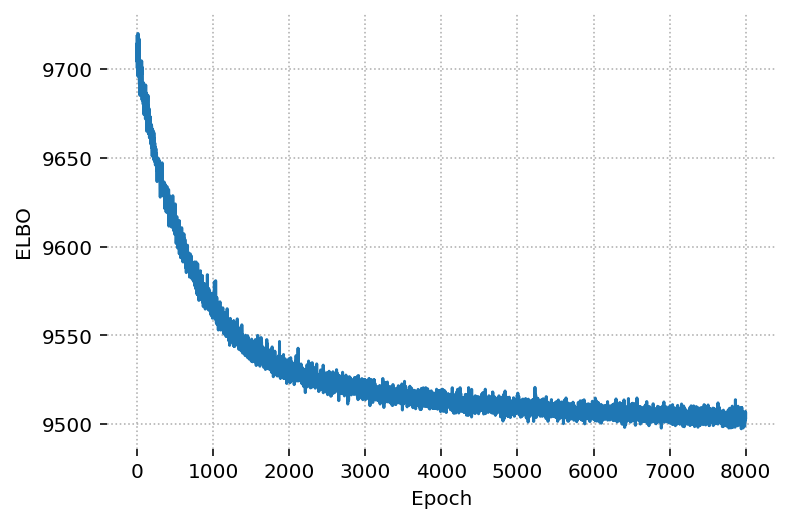

In [361]:
plt.plot(model_de.loss[2000:])
plt.xlabel('Epoch')
plt.ylabel('ELBO')

In [362]:
import importlib
importlib.reload(gs.misc.misc)
importlib.reload(gs.misc)
from genomicsurveillance.misc import MultiLineageTimeShift, plot_lad, plot_growth_rates, get_transmissibility

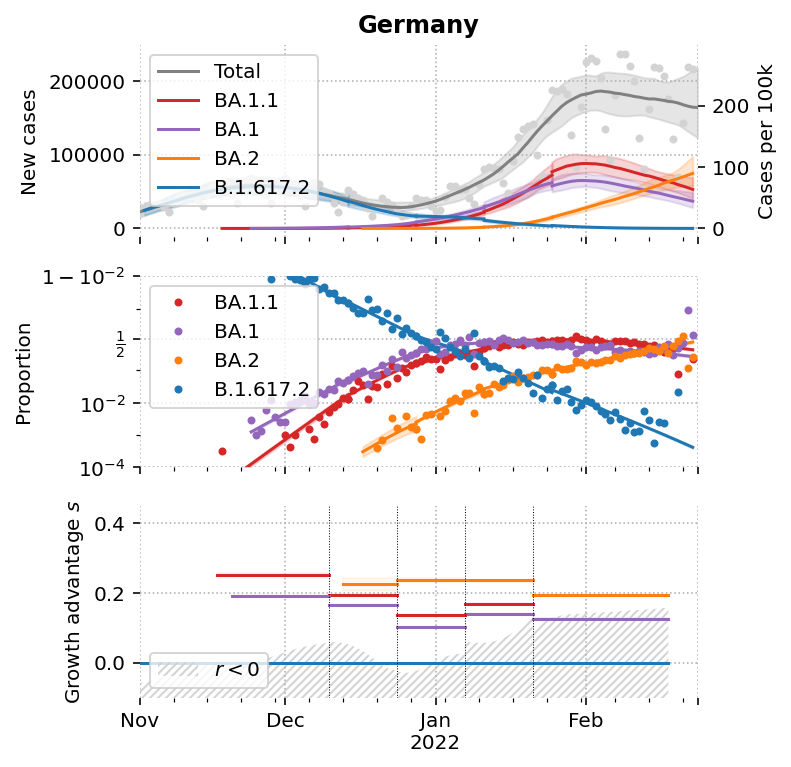

In [363]:
for j,i in enumerate(range(bar.shape[0]-1,-1, -1)):
    w = [1,0,2,5]#np.arange(genomes.shape[1]) #if i == 2 else [0,2]
    plot_lad(model_de, i, 
             #model_uk.cases, model_uk.lineages, np.array([cases_uk.index.to_list().index(i) for i in genomes_uk.index]), 
             start_date="2021-11-01", 
             show_start_date="2021-11-01",
            lin = w,
            labels = genomes.columns[w],
            lin_colors=np.array(['C4','C3', "C1" ,"C9", "C0","C0"])[w],#, "C6", "C1","C8"],
            #labels=[alias(y) if alias(y) != "AY.121" else "Orf3a:202L" for y in x],#["B.1.1.7", 'Delta', "AY.4", 'B.1.617.2.5', "B.1.177"],
            case_color="grey",
            case_markercolor="lightgrey",
                figsize=(5,6),
                prop_err=False,
            clip_to_lineage_data = True,
             add = j,
            bleed_left = -1,
             bleed_right= 5 if j == 0 else -1,
             show_Rt = False,
             plot_s= True,
             plot_r = True
            )

ax=plt.gcf().get_axes()
    
ax[0].set_title("Germany", size=12, weight='bold')

ax[1].set_yscale("logit")
ax[1].set_ylim((1e-4,1-1e-2))
ax[2].set_ylim((-.1,.45))
ax[1].legend(facecolor='white')
#ax[2].legend().remove()
ax[2].legend(loc='lower left')#.remove()
ax[3].grid(False)
for i,a in enumerate(ax[:-1]):
    a.grid(ls=":")
    for dd in date_split:
        x = dd 
        if i ==2:
            x -= np.timedelta64(int(model.tau), "D")
            a.axvline(x, ls=":", color='k', lw=0.5)
plt.delaxes(ax[3])



In [364]:
pd.DataFrame(get_transmissibility(model_de), columns=genomes.columns)

lineage      BA.1    BA.1.1      BA.2      BA.3     Other  B.1.617.2
0        0.191420  0.252462  0.021681  0.042103  0.074427        0.0
1        0.165376  0.194052  0.223760  0.042103  0.086572        0.0
2        0.102504  0.135664  0.237153  0.133593  0.063556        0.0
3        0.140669  0.169088  0.236354 -0.056527 -0.127477        0.0
4        0.124018  0.126526  0.194083  0.188843  0.192795        0.0

n  Growth rate r to ancestor      +/-   \
Lineage                                                  
BA.1        64760                   0.018187  0.031125   
BA.1.1      62333                   0.018127  0.045396   
BA.2        14991                   0.021681  0.017539   
BA.3           25                   0.042103  0.110309   
Other         274                   0.031535  0.103882   
B.1.617.2  137593                   0.000000  0.000000   

           Growth rate r to baseline BA.1       +/-  
Lineage                                              
BA.1                             0.000000  0.031125  
BA.1.1                           0.030761  0.045396  
BA.2                             0.078040  0.017539  
BA.3                            -0.056161  0.110309  
Other                           -0.086823  0.103882  
B.1.617.2                       -0.144798  0.000000

/Users/mg14/Downloads/desh-data/genomicsurveillance/misc/misc.py:876: RuntimeWarning: divide by zero encountered in log
  ax3.set_ylabel("Approximate $R_t$ ratio")


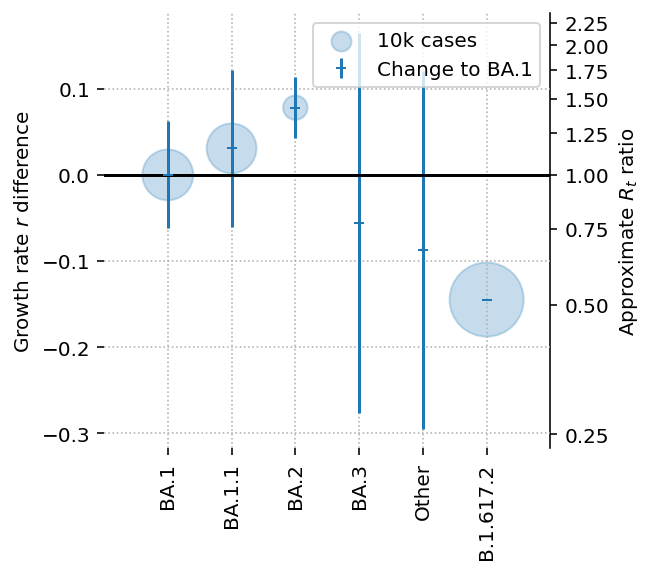

In [365]:
plt.figure(figsize=(4,4))
plot_growth_rates(model_de, genomes.columns.to_list(), color=["C0","None"], baseline="BA.1")


## Denmark

In [ ]:
cases_dk = pd.read_csv("../overvaagningsdata-dashboard-covid19-31012022-40ip/Regionalt_DB/08_bekraeftede_tilfaelde_pr_dag_pr_regions.csv", index_col=[0,1],parse_dates=True, encoding='latin_1', sep=";").sum(level=1).loc["2021-11-01":].iloc[:-1,0]

In [ ]:
cases_dk

In [ ]:
x = []
c = "Denmark"
for v in ['BA.1','BA.1.1', 'BA.2', 'BA.3', 'B.1.617.2*']:
    r = requests.get(f"https://lapis.cov-spectrum.org/gisaid/v1/sample/aggregated?fields=date&host=Human&country={c}&dateFrom=2021-11-01&dateTo={np.datetime64('today')}&pangoLineage={v}") #&dataVersion=1642092398
    d = pd.DataFrame(r.json()['data'])
    try:
        x.append(pd.DataFrame({v: d['count'].values}, index=pd.DatetimeIndex(d.date)).sort_index()[v])
    except:
        pass


genomes_dk = pd.DataFrame(x).T.fillna(0)#
genomes_dk = genomes_dk.loc[genomes_dk.index <= cases_dk.index.max(),:]
genomes_dk.sum(0)

In [ ]:
date_split = np.datetime64("2021-12-14") + np.arange(0,6,2).astype("timedelta64[W]")#[np.datetime64("2021-12-12"), np.datetime64("2021-12-31")]

In [ ]:
foo = np.stack((len(date_split)+1) * [cases_dk["2021-11-01":].values], axis=0)
bar = np.stack((len(date_split)+1)  * [genomes_dk.values], axis=0)
for i, dd in enumerate(date_split):
    bar[i,genomes_dk.index > dd,:] = 0
    bar[i+1,genomes_dk.index <= dd,:] = 0


In [ ]:
model_dk = MultiLineageTimeShift(
    foo, #cases_uk["2021-11-01":].values.reshape(1,-1),
    bar,    
    np.array([cases_dk.index.to_list().index(i) for i in genomes_dk.index]),
    np.repeat(5.831e6,len(date_split)+1),
    #auto_correlation=0.5,
    #linearize=True,
    arma = arma2,
    b_scale=0.1,
    b0_scale=0.5,
    c_scale=5,
    beta_scale= np.append(10.,np.repeat(10., B0.shape[2]-1)),# np.concatenate([np.repeat(1., knots.num_long_basis), np.repeat(.1, knots.num_short_basis)]),
    tau=4.6,
    basis=B0, #knots.basis,
    shift=7,  
    alpha0=.01,
    alpha1=10000., 
    week=True,
    #model_kwargs={'handler':'SVI', 'loss':Trace_ELBO(num_particles=5), 'num_epochs':10000, 'lr':0.001, 'num_samples': 100}
    model_kwargs={'handler':'SVI', 'loss':Trace_ELBO(num_particles=10), 'num_epochs':12000, 'lr':0.005, 'lrd': 0.1 ** (1/10000), 'num_samples': 100}

)

In [ ]:
foo.shape

In [ ]:
model_dk.fit()

In [ ]:
plt.plot(model_dk.loss[2000:])
plt.xlabel('Epoch')
plt.ylabel('ELBO')

In [ ]:
import importlib
importlib.reload(gs.misc.misc)
importlib.reload(gs.misc)
from genomicsurveillance.misc import MultiLineageTimeShift, plot_lad, plot_growth_rates, get_transmissibility

In [ ]:
for j,i in enumerate(range(bar.shape[0]-1,-1, -1)):
    w = [0,1,2,3]#np.arange(genomes.shape[1]) #if i == 2 else [0,2]
    plot_lad(model_dk, i, 
             #model_uk.cases, model_uk.lineages, np.array([cases_uk.index.to_list().index(i) for i in genomes_uk.index]), 
             start_date="2021-11-01", 
             show_start_date="2021-11-01",
            lin = w,
            labels = genomes_dk.columns[w],
            lin_colors=np.array(['C3','C4', "C1" ,"C0", "C0","C0"])[w],#, "C6", "C1","C8"],
            #labels=[alias(y) if alias(y) != "AY.121" else "Orf3a:202L" for y in x],#["B.1.1.7", 'Delta', "AY.4", 'B.1.617.2.5', "B.1.177"],
            case_color="grey",
            case_markercolor="lightgrey",
                figsize=(5,6),
                prop_err=False,
            clip_to_lineage_data = True,
             add = j,
            bleed_left = 1,
             bleed_right=3 if j ==0 else 1,
             show_Rt = False,
             plot_s= True
            )

ax=plt.gcf().get_axes()
    
ax[0].set_title("Denmark", size=12, weight='bold')

#ax[1].set_yscale("logit")
#ax[1].set_ylim((1e-4,1-1e-2))
ax[2].set_ylim((-.1,.45))
ax[1].legend().remove()
ax[1].legend(facecolor='white')
ax[2].legend(loc='lower right')#.remove()
ax[3].grid(False)
for i,a in enumerate(ax[:-1]):
    a.grid(ls=":")
    for dd in date_split:
        x = dd 
        if i ==2:
            x -= np.timedelta64(int(model.tau), "D")
            a.axvline(x, ls=":", color='k', lw=0.5)
plt.delaxes(ax[3])


In [ ]:
(bar[-1,-15:] )

In [ ]:
genomes_dk

In [ ]:
plt.figure(figsize=(4,4))
plot_growth_rates(model_dk, genomes_dk.columns.to_list(), color=["C0","None"], baseline="BA.1")
